# 01to06_core_analysis

#### Hardware and runtime

All experiments were run locally on a MacBook Pro (16-inch, November 2024) with an Apple M4 Pro chip (14 CPU cores: 10 performance and 4 efficiency cores) and 24 GB unified memory, running macOS Tahoe 26.2. All steps were executed on CPU, and no distributed computing frameworks (for example SLURM or OpenPBS) were used.

**Runtime:** On the hardware above, the notebook completes in approximately **5 minutes**. Runtime may vary slightly depending on installed package versions and whether optional diagnostics are enabled.

## Table of contents

| Section | Description |
|---|---|
| 01_preprocessing | Filters UK Trustpilot reviews by country, date range, and language using `TrustpilotDataFilter` and `detect_language` (defined in this notebook), then applies `TextPreprocessor` (imported from `utils.processing.text_preprocessor`) to generate modelling-ready text. |
| 02_eda_and_split_negative_review_data | Produces word-frequency tables and word clouds for all, negative, and non-negative reviews using `Plotter` (defined in this notebook), then splits the dataset into negative vs non-negative using the configured rating thresholds. |
| 03_topic_modelling_bertopic | Runs BERTopic on negative reviews via `BERTopicRunner` (imported from `modelling.bertopic.bertopic_runner`), using configured UMAP settings and saving topic tables and plots for reporting. |
| 04a_emotion_analysis_roberta | Performs transformer emotion classification (DistilRoBERTa) using `Initialiser`, `EmotionParams`, and `EmotionModelDataCompiler` (all defined in this notebook), plus `bar_plot` (defined in this notebook) for emotion distribution plots. |
| 04b_emotion_analysis_bert_base_uncased | Repeats the same emotion pipeline for comparison using the second model in `EmotionParams` (defined in this notebook), reusing `Initialiser`, `EmotionModelDataCompiler`, and `bar_plot` (all defined in this notebook). |
| 05_topic_modelling_bertopic_per_emotion_neg_reviews | Runs BERTopic per emotion on negative reviews (for example sadness) using `BERTopicRunner` (imported), enforcing a minimum document threshold and exporting topic summaries and visualisations. |
| 06_topic_modelling_lda_gensim | Trains and evaluates Gensim LDA baselines and exports pyLDAvis artefacts using the in-notebook pipeline `LDAConfig`, `LDARunner`, `LDAEvaluator`, `PreprocessedTokeniser`, `GensimCorpusBuilder`, and `run_emotion_subset` (all defined in this notebook). |


In [23]:
from pathlib import Path
import sys
import ast
from configparser import ConfigParser

import numpy as np
import random
import pandas as pd

import re

# Resolve project root as the parent of the folder the notebook is currently in
CWD = Path.cwd().resolve()
PROJECT_ROOT = CWD.parent

# Safety fallback
if not (PROJECT_ROOT / "config.ini").exists():
    PROJECT_ROOT = next((p for p in (CWD, *CWD.parents) if (p / "config.ini").exists()), None)
    if PROJECT_ROOT is None:
        raise FileNotFoundError("Could not locate 'config.ini' in the current directory or its parents.")

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

CONFIG = ConfigParser()
CONFIG.read(PROJECT_ROOT / "config.ini")

print("CONFIG used:")
for section in CONFIG.sections():
    print(f"\n[{section}]")
    for key, value in CONFIG[section].items():
        print(f"{key} = {value}")


CONFIG used:

[DATA]
data_dir = data
raw_filename = PureGym Customer Reviews.csv
raw_filename_filtered = PureGym Customer Reviews_raw_filtered.csv
preprocessed_filename = PureGym Customer Reviews_preprocessed.csv
preprocessed_filename_sentiment = PureGym Customer Reviews_preprocessed_sentiment.csv
preprocessed_filename_negative = PureGym Customer Reviews_preprocessed_negative.csv
preprocessed_filename_non_negative = PureGym Customer Reviews_preprocessed_non_negative.csv
preprocessed_filename_emotion = PureGym Customer Reviews_preprocessed_emotion.csv
preprocessed_filename_negative_emotion = PureGym Customer Reviews_preprocessed_negative_emotion.csv
preprocessed_filename_non_negative_emotion = PureGym Customer Reviews_preprocessed_non_negative_emotion.csv

[OUTPUT]
plot_dir = output/plots
table_dir = output/tables
model_dir = output/models

[FILTERING]
selected_cols = ["Rating", "Date Experienced", "Review Title", "Review"]
country_code = GB
text_col = Review
detect_language = en
negati

In [24]:
SEED = CONFIG["REPRODUCIBILITY"].getint("SEED")
random.seed(SEED)
np.random.seed(SEED)

In [25]:
import time

NOTEBOOK_T0_GLOBAL = time.perf_counter()
print("Notebook timer started.")

Notebook timer started.


# 01_preprocessing

This section performs all preprocessing required prior to modelling and analysis:

- Filters the raw Trustpilot dataset by country (UK), date range, language, and selected variables.

- Applies text preprocessing (normalisation, contraction handling, lemmatisation, punctuation and digit removal, stopword filtering).

- Produces separate preprocessed datasets for topic modelling and for sentiment or emotion analysis.

**Outputs (data/):**

- `PureGym Customer Reviews_raw_filtered.csv`

- `PureGym Customer Reviews_preprocessed.csv`

- `PureGym Customer Reviews_preprocessed_sentiment.csv`

**Compute and reproducibility:**

- Local run on MacBook Pro (16-inch, Nov 2024), Apple M4 Pro (14 CPU cores), 24 GB unified memory, macOS Tahoe 26.2.

- CPU-only execution, no distributed frameworks.

- Fixed random seed: **901**.


In [26]:
NOTEBOOK_T0 = time.perf_counter()
print("Section timer started.")

Section timer started.


In [27]:
from typing import Iterable, Optional, Callable

from utils.data_management.data_io import load_csv, save_csv
from utils.processing.text_preprocessor import TextPreprocessor

from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

In [28]:
# FILTERING
SELECTED_COLS = ast.literal_eval(CONFIG["FILTERING"]["SELECTED_COLS"])

COUNTRY_CODE = CONFIG["FILTERING"]["COUNTRY_CODE"]
TEXT_COL = CONFIG["FILTERING"]["TEXT_COL"]
DETECT_LANGUAGE = CONFIG["FILTERING"]["DETECT_LANGUAGE"]

# ANALYSIS DATES
DATE_COL = CONFIG["ANALYSIS_DATES"]["DATE_COL"]
START_DATE = CONFIG["ANALYSIS_DATES"]["START_DATE"]
END_DATE = CONFIG["ANALYSIS_DATES"]["END_DATE"]

# REPRODUCIBILITY
DetectorFactory.seed = SEED  # Configure langdetect RNG once

# DATA
DATA_DIR = (PROJECT_ROOT / CONFIG["DATA"]["DATA_DIR"]).resolve()
DATA_DIR.mkdir(parents=True, exist_ok=True)

RAW_FILENAME = CONFIG["DATA"]["RAW_FILENAME"]
RAW_PATH = f"{DATA_DIR}/{RAW_FILENAME}"

# PREPROCESSING 
STOPWORD_LANGUAGE = "english"
EXTRA_STOPWORDS = ["pure", "gym", "puregym", "equipment"]

PUNCTUATION_PATTERN_TOPIC = r"[-.,\"'’`;:!?()/&%]+"
USE_POS_TAGGING_TOPIC = False

PUNCTUATION_PATTERN_SENTIMENT = r"[-.,\"'’`;:()/&%]+"
USE_POS_TAGGING_SENTIMENT = True

In [30]:
def detect_language(text: Optional[str]) -> str:
    """
    Detect the language of a text string.

    Parameters
    ----------
    text : str or None
        Input text.

    Returns
    -------
    str
        ISO 639-1 language code or ``"unknown"`` if detection fails.
    """
    if not isinstance(text, str) or not text.strip():
        return "unknown"

    try:
        return detect(text)
    except LangDetectException:
        return "unknown"

In [31]:
class TrustpilotDataFilter:
    """
    Apply standardised filtering operations to Trustpilot review data.

    Parameters
    ----------
    selected_columns : list[str]
        Columns to retain in the final output DataFrame.
    date_column : str
        Name of the column containing review dates.
    start_date : str or pandas.Timestamp
        Inclusive start date for filtering.
    end_date : str or pandas.Timestamp
        Inclusive end date for filtering.
    country_code : str or None, optional
        Country code to filter on. If ``None``, no country filtering is applied.
    language_detector : Callable[[str | None], str], optional
        Function used to detect language from text.
    text_column : str
        Column used for language detection.
    allowed_languages : Iterable[str] or None, optional
        Languages to retain. If ``None``, no language filtering is applied.
    """

    def __init__(
        self,
        selected_columns: list[str],
        date_column: str,
        start_date,
        end_date,
        country_code: Optional[str] = None,
        language_detector: Callable[[Optional[str]], str] = detect_language,
        text_column: str = "Review",
        allowed_languages: Optional[Iterable[str]] = ("en",),
    ) -> None:
        self.selected_columns = selected_columns
        self.date_column = date_column
        self.start_date = pd.Timestamp(start_date)
        self.end_date = pd.Timestamp(end_date)
        self.country_code = country_code
        self.language_detector = language_detector
        self.text_column = text_column
        self.allowed_languages = allowed_languages

    def apply(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Apply all configured filters to the dataset.

        Parameters
        ----------
        df : pandas.DataFrame
            Raw Trustpilot dataset.

        Returns
        -------
        pandas.DataFrame
            Filtered dataset containing only the selected columns.
        """
        df_filtered = df.copy()

        df_filtered = self._filter_country(df_filtered)
        df_filtered = self._parse_dates(df_filtered)
        df_filtered = self._filter_date_range(df_filtered)
        df_filtered = self._filter_language(df_filtered)
        df_filtered = self._select_columns(df_filtered)

        return df_filtered

    def _filter_country(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Filter reviews by country code.
        """
        if self.country_code is None:
            return df

        return df[df["Country Code"] == self.country_code]

    def _parse_dates(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Parse the date column into pandas datetime format.
        """
        df = df.copy()
        df[self.date_column] = pd.to_datetime(df[self.date_column], errors="coerce")
        return df

    def _filter_date_range(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Filter reviews within the specified date range.
        """
        mask = (
            (df[self.date_column] >= self.start_date) &
            (df[self.date_column] <= self.end_date)
        )
        return df[mask]

    def _filter_language(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Filter reviews by detected language.
        Language detection is performed temporarily and the helper
        column is dropped before returning the dataset.
        """
        if self.allowed_languages is None:
            return df

        df = df.copy()
        df["_detected_language"] = df[self.text_column].apply(self.language_detector)

        df = df[df["_detected_language"].isin(self.allowed_languages)]
        df = df.drop(columns="_detected_language")

        return df

    def _select_columns(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Select the final output columns.
        """
        return df[self.selected_columns].copy()

### Load raw data

In [32]:
df_trustpilot = load_csv(RAW_PATH)
df_trustpilot.head()

,Total Reviews,Profile Image,Customer Name,Country Code,Rating,Date Experienced,Review Title,Review,Owner,Owner Date Posted,Owners Response
0,1,EC,Elena Curtis,GB,4,2023-12-17,"A well equipped gym, lacked cleaning facilities",a well equipped gym and only noticed one machi...,PureGym UK,No Date Provided,No Response Provided
1,4,Custom Image,Graham F,GB,4,2023-12-13,Overall a good experience,overall a good experience. its still too cramp...,PureGym UK,2 days ago,Hi Graham. Thanks for taking the time to leave...
2,8,IO,Ian Oldham,GB,5,2023-12-12,Excellent gym,"excellent gym, friendly environment, plenty of...",PureGym UK,2 days ago,Hi Ian. Thanks for taking the time to leave th...
3,15,MB,Mick Bayley,GB,5,2023-11-12,I'm going to be so fit,havnt been a gym member for 20 years but this ...,PureGym UK,No Date Provided,No Response Provided
4,1,LU,Lucy,GB,5,2023-12-13,Chloe Lawrence PT at PureGym,i have been training with chloe lawrence at pu...,PureGym UK,2 days ago,Hi Lucy. Thanks for taking the time to leave t...


### Data Quality Checks

In [34]:
print("Number of Missing Comments in Trustpilot Reviews Dataset:", df_trustpilot[TEXT_COL].isna().sum())
print("Number of duplicates in Trustpilot Reviews Dataset:", df_trustpilot.duplicated().sum())

Number of Missing Comments in Trustpilot Reviews Dataset: 0
Number of duplicates in Trustpilot Reviews Dataset: 0


### Apply Filters

In [35]:
trustpilot_filter = TrustpilotDataFilter(
    selected_columns=SELECTED_COLS,   # Columns to keep in final dataset
    date_column=DATE_COL,           # Review date field
    start_date=START_DATE,               # Inclusive start date
    end_date=END_DATE,                   # Inclusive end date
    country_code=COUNTRY_CODE,           # Filter to UK reviews only
    text_column=TEXT_COL,                # Text used for language detection
    allowed_languages=(DETECT_LANGUAGE ,)   # Keep English-language reviews
)

df_trustpilot = trustpilot_filter.apply(df_trustpilot)  

In [36]:
# Validate language filtering (approx. 1min - set to false to save time)
VALIDATE_LANGUAGE = False
if VALIDATE_LANGUAGE:
    language_check = df_trustpilot[TEXT_COL].apply(detect_language)
    language_counts = (
        pd.Series(language_check)
        .value_counts(dropna=False)
        .sort_index()
    )
    display(language_counts)

In [37]:
# Save raw filtered (no text preprocessing yet)
save_csv(
    df_trustpilot,
    RAW_PATH,
    suffix="_raw_filtered",
)

print("Saved raw filtered dataset to:", Path(RAW_PATH).with_name(f"{Path(RAW_PATH).stem}_raw_filtered{Path(RAW_PATH).suffix}"))
display(df_trustpilot.head())

Saved raw filtered dataset to: C:\Users\joshu\Desktop\Final Assignment\PureGym-NLP-UDA\data\PureGym Customer Reviews_raw_filtered.csv


,Rating,Date Experienced,Review Title,Review
0,4,2023-12-17,"A well equipped gym, lacked cleaning facilities",a well equipped gym and only noticed one machi...
1,4,2023-12-13,Overall a good experience,overall a good experience. its still too cramp...
2,5,2023-12-12,Excellent gym,"excellent gym, friendly environment, plenty of..."
3,5,2023-11-12,I'm going to be so fit,havnt been a gym member for 20 years but this ...
4,5,2023-12-13,Chloe Lawrence PT at PureGym,i have been training with chloe lawrence at pu...


### Apply Text Preprocessor for Topic Modelling

In [38]:
# Apply text preprocessor for topic modelling
df_trustpilot[TEXT_COL] = TextPreprocessor(
    punctuation_pattern=PUNCTUATION_PATTERN_TOPIC,
    extra_stopwords=EXTRA_STOPWORDS,
    use_pos_tagging=USE_POS_TAGGING_TOPIC,
    language=STOPWORD_LANGUAGE,
).transform_many(df_trustpilot[TEXT_COL])

In [39]:
display(df_trustpilot.head())

,Rating,Date Experienced,Review Title,Review
0,4,2023-12-17,"A well equipped gym, lacked cleaning facilities",well equipped noticed one machine order disapp...
1,4,2023-12-13,Overall a good experience,overall good experience still cramped compared...
2,5,2023-12-12,Excellent gym,excellent friendly environment plenty choice s...
3,5,2023-11-12,I'm going to be so fit,havnt member year state art brand new friendly...
4,5,2023-12-13,Chloe Lawrence PT at PureGym,training chloe lawrence month soon finish th m...


### Save Processed Data for Topic Modelling

In [40]:
save_csv(
    df_trustpilot,
    RAW_PATH,
    suffix="_preprocessed"
)

WindowsPath('C:/Users/joshu/Desktop/Final Assignment/PureGym-NLP-UDA/data/PureGym Customer Reviews_preprocessed.csv')

### Apply Text Preprocessor for Sentiment/Emotion Data

In [41]:
# Apply text preprocessor for sentiment/emotion data
df_trustpilot_sentiment = df_trustpilot.copy()

df_trustpilot_sentiment[TEXT_COL] = TextPreprocessor(
    punctuation_pattern=PUNCTUATION_PATTERN_SENTIMENT,
    extra_stopwords=EXTRA_STOPWORDS,
    use_pos_tagging=USE_POS_TAGGING_SENTIMENT,
    language=STOPWORD_LANGUAGE,
).transform_many(df_trustpilot_sentiment[TEXT_COL])

### Save Processed Sentiment/Emotion Data

In [42]:
sentiment_save_path = save_csv(
    df_trustpilot_sentiment,
    RAW_PATH,
    suffix="_preprocessed_sentiment",
)

print("Saved sentiment/emotion preprocessed dataset to:", sentiment_save_path)

Saved sentiment/emotion preprocessed dataset to: C:\Users\joshu\Desktop\Final Assignment\PureGym-NLP-UDA\data\PureGym Customer Reviews_preprocessed_sentiment.csv


In [43]:
elapsed_s = time.perf_counter() - NOTEBOOK_T0
elapsed_m = elapsed_s / 60

print(f"\nTotal runtime: {elapsed_s:,.1f} seconds ({elapsed_m:,.2f} minutes)")


Total runtime: 67.4 seconds (1.12 minutes)


# 02_eda_and_split_negative_review_data

This section performs exploratory analysis on the preprocessed dataset and prepares modelling subsets:

- Produces word-frequency tables and word clouds for all reviews, negative reviews, and non-negative reviews.

- Splits the dataset into negative and non-negative subsets using rating thresholds from the configuration.

**Outputs (data/):**

- `PureGym Customer Reviews_preprocessed_negative.csv`

- `PureGym Customer Reviews_preprocessed_non_negative.csv`

**Additional outputs:** plots and tables under `output/plots/02_eda_and_split_negative_review_data/` and `output/tables/02_eda_and_split_negative_review_data/`.

**Compute and reproducibility:** CPU-only local execution, fixed random seed **901**.


In [44]:
import time

NOTEBOOK_T0 = time.perf_counter()
print("Notebook timer started.")

Notebook timer started.


In [45]:
PLOT_DIR = PROJECT_ROOT / CONFIG["OUTPUT"]["PLOT_DIR"] / "02_eda_and_split_negative_review_data"
TABLE_DIR = PROJECT_ROOT / CONFIG["OUTPUT"]["TABLE_DIR"] / "02_eda_and_split_negative_review_data"

PLOT_DIR.mkdir(parents=True, exist_ok=True)
TABLE_DIR.mkdir(parents=True, exist_ok=True)

# DATA
DATA_DIR = (PROJECT_ROOT / CONFIG["DATA"]["DATA_DIR"]).resolve()
DATA_DIR.mkdir(parents=True, exist_ok=True)
RAW_FILENAME = CONFIG["DATA"]["RAW_FILENAME"]
PREPROCESSED_FILENAME = CONFIG["DATA"]["PREPROCESSED_FILENAME"]
PREPROCESSED_PATH = f"{DATA_DIR}/{PREPROCESSED_FILENAME}"


TEXT_COL = CONFIG["FILTERING"]["TEXT_COL"]  
SEED = CONFIG["REPRODUCIBILITY"].getint("SEED")


TOP_N = 10 # Number of words to show in bar plots

In [46]:
# Standard
import ast
import warnings
from collections import Counter
from typing import Iterable, Sequence, Optional

# Data handling
import pandas as pd
import numpy as np
pd.set_option("display.max_colwidth", None)

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Project utilities
from utils.data_management.data_io import load_csv, save_csv

warnings.filterwarnings("ignore")

In [47]:
# Load preprocessed Trustpilot data
df_trustpilot = load_csv(PREPROCESSED_PATH)

### Plotter Class

In [48]:
class Plotter:
    """
    Create, display, and save common NLP plots.
    """

    def __init__(self, output_dir: str | Path = "output/plots") -> None:
        self._output_dir = Path(output_dir)
        self._output_dir.mkdir(parents=True, exist_ok=True)

    @property
    def output_dir(self) -> Path:
        return self._output_dir

    def _save_figure(self, fig: plt.Figure, filename: str) -> Path:
        save_path = self._output_dir / filename
        fig.savefig(save_path, bbox_inches="tight")
        return save_path

    def plot_word_frequencies(
        self,
        words: Sequence[str],
        counts: Sequence[int],
        *,
        title: str,
        filename: str,
        rotation: int = 45,
        figsize: float = 6.0,
        show: bool = True,
    ) -> Path:
        """
        Plot, display, and save a word frequency bar chart.
        """
        if len(words) != len(counts):
            raise ValueError("words and counts must have the same length")

        fig, ax = plt.subplots(figsize=(figsize, figsize))
        ax.bar(words, counts)
        ax.set_title(title)
        ax.set_xlabel("Words")
        ax.set_ylabel("Frequency")
        ax.tick_params(axis="x", rotation=rotation)
        fig.tight_layout()

        if show:
            plt.show()

        path = self._save_figure(fig, filename)
        plt.close(fig)
        return path

    def plot_wordcloud(
        self,
        tokens: Iterable[str],
        *,
        title: str,
        filename: str,
        seed: Optional[int] = None,
        width: int = 800,
        height: int = 800,
        background_color: str = "white",
        max_words: int = 200,
        figsize: float = 6.0,
        show: bool = True,
    ) -> Path:
        """
        Plot, display, and save a word cloud.

        Parameters
        ----------
        seed
            Random seed for word cloud layout. If ``None``, randomness is uncontrolled.
        """
        text = " ".join(str(t) for t in tokens if t is not None)

        wc = WordCloud(
            width=width,
            height=height,
            background_color=background_color,
            max_words=max_words,
            random_state=seed,
        ).generate(text)

        fig, ax = plt.subplots(figsize=(figsize, figsize))
        ax.imshow(wc, interpolation="bilinear")
        ax.set_title(title)
        ax.axis("off")
        fig.tight_layout()

        if show:
            plt.show()

        path = self._save_figure(fig, filename)
        plt.close(fig)
        return path

In [49]:
# Instantiate plotter
plotter = Plotter(output_dir=PLOT_DIR)

### Plots: All Reviews

In [50]:
# Tokenise preprocessed text
tokens_trustpilot = (
    df_trustpilot[TEXT_COL]
    .dropna()
    .astype(str)
    .str.split()
    .explode()
)

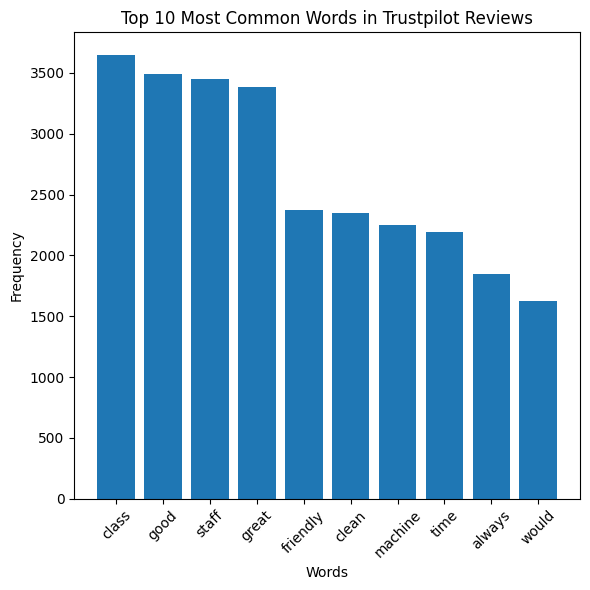

Saved frequency plot to: C:\Users\joshu\Desktop\Final Assignment\PureGym-NLP-UDA\output\plots\02_eda_and_split_negative_review_data\trustpilot_top10_words.png


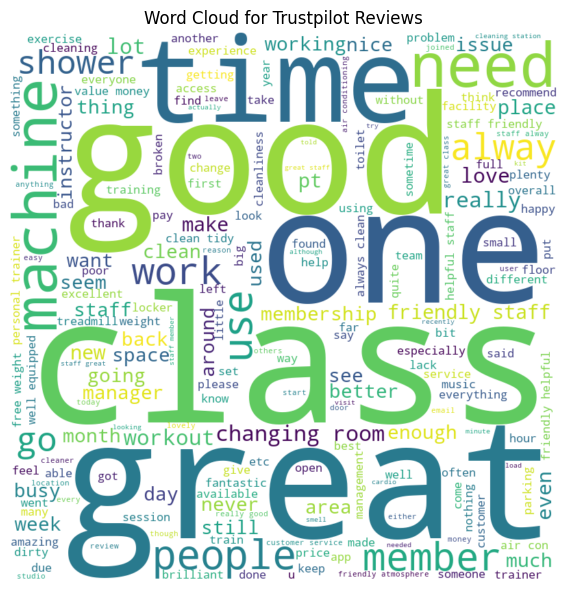

Saved wordcloud to: C:\Users\joshu\Desktop\Final Assignment\PureGym-NLP-UDA\output\plots\02_eda_and_split_negative_review_data\trustpilot_wordcloud.png
Saved top words table to: C:\Users\joshu\Desktop\Final Assignment\PureGym-NLP-UDA\output\tables\02_eda_and_split_negative_review_data\trustpilot_top10_words.csv


In [51]:
# Word frequency calculation
token_counts = Counter(tokens_trustpilot)
common_words = token_counts.most_common(TOP_N)

# Save top words table
df_top_words_all = pd.DataFrame(common_words, columns=["word", "count"])
df_top_words_all.to_csv(TABLE_DIR / "trustpilot_top10_words.csv", index=False)

words, counts = zip(*common_words) if common_words else ([], [])

# Plot and save word frequencies
freq_plot_path = plotter.plot_word_frequencies(
    words=words,
    counts=counts,
    title="Top 10 Most Common Words in Trustpilot Reviews",
    filename="trustpilot_top10_words.png",
)

print(f"Saved frequency plot to: {freq_plot_path}")

# Plot and save wordcloud
wordcloud_path = plotter.plot_wordcloud(
    tokens=tokens_trustpilot,
    title="Word Cloud for Trustpilot Reviews",
    filename="trustpilot_wordcloud.png",
    seed=SEED,
)

print(f"Saved wordcloud to: {wordcloud_path}")
print(f"Saved top words table to: {TABLE_DIR / 'trustpilot_top10_words.csv'}")

### Create and Save Sub-dataframes

In [52]:
# View counts for each Rating level
df_trustpilot["Rating"].value_counts()

Rating
5    5237
4    2177
1    1524
3    1518
2     844
Name: count, dtype: int64

In [53]:
# Split into negative / non-negative
NEGATIVE_RATINGS = ast.literal_eval(CONFIG["FILTERING"].get("NEGATIVE_RATINGS", "[]"))

df_negative = df_trustpilot[df_trustpilot["Rating"].isin(NEGATIVE_RATINGS)].copy()
df_non_negative = df_trustpilot[~df_trustpilot["Rating"].isin(NEGATIVE_RATINGS)].copy()

print("Negative ratings:", NEGATIVE_RATINGS)
print("All reviews:", len(df_trustpilot))
print("Negative reviews:", len(df_negative))
print("Non-negative reviews:", len(df_non_negative))

Negative ratings: [1, 2]
All reviews: 11300
Negative reviews: 2368
Non-negative reviews: 8932


In [54]:
# Save split datasets to data folder
negative_suffix = "_negative"
non_negative_suffix = "_non_negative"

negative_save_path = save_csv(
    df_negative,
    PREPROCESSED_PATH,
    suffix=negative_suffix,
)

non_negative_save_path = save_csv(
    df_non_negative,
    PREPROCESSED_PATH,
    suffix=non_negative_suffix,
)

print(f"Saved negative reviews to: {negative_save_path}")
print(f"Saved non-negative reviews to: {non_negative_save_path}")

Saved negative reviews to: C:\Users\joshu\Desktop\Final Assignment\PureGym-NLP-UDA\data\PureGym Customer Reviews_preprocessed_negative.csv
Saved non-negative reviews to: C:\Users\joshu\Desktop\Final Assignment\PureGym-NLP-UDA\data\PureGym Customer Reviews_preprocessed_non_negative.csv


### Plots: Negative Reviews

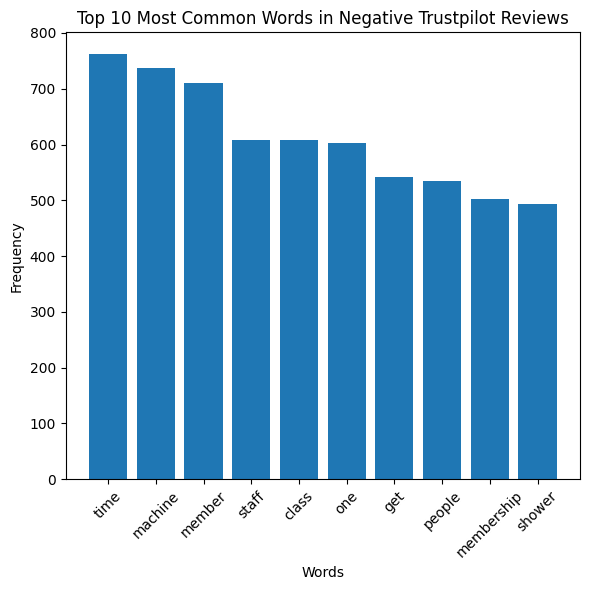

Saved negative frequency plot to: C:\Users\joshu\Desktop\Final Assignment\PureGym-NLP-UDA\output\plots\02_eda_and_split_negative_review_data\trustpilot_negative_top10_words.png


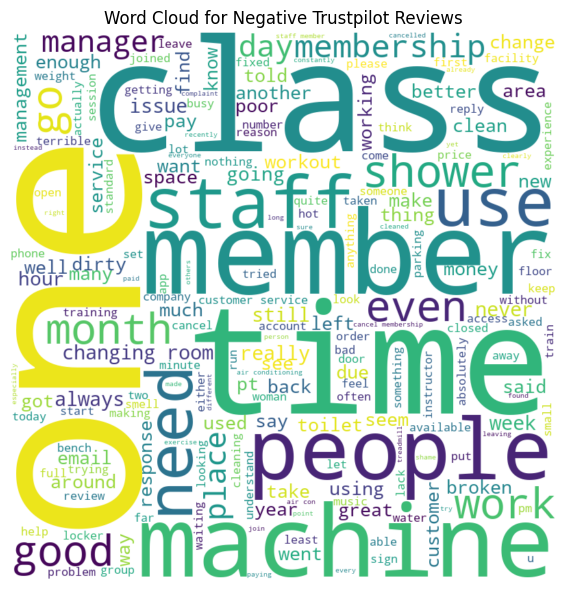

Saved negative wordcloud to: C:\Users\joshu\Desktop\Final Assignment\PureGym-NLP-UDA\output\plots\02_eda_and_split_negative_review_data\trustpilot_negative_wordcloud.png
Saved negative top words table to: C:\Users\joshu\Desktop\Final Assignment\PureGym-NLP-UDA\output\tables\02_eda_and_split_negative_review_data\trustpilot_negative_top10_words.csv


In [55]:
tokens_negative = (
    df_negative[TEXT_COL]
    .dropna()
    .astype(str)
    .str.split()
    .explode()
)

token_counts_negative = Counter(tokens_negative)
common_words_negative = token_counts_negative.most_common(TOP_N)

# Save top words table
df_top_words_negative = pd.DataFrame(common_words_negative, columns=["word", "count"])
df_top_words_negative.to_csv(TABLE_DIR / "trustpilot_negative_top10_words.csv", index=False)

words_neg, counts_neg = zip(*common_words_negative) if common_words_negative else ([], [])

freq_plot_path_negative = plotter.plot_word_frequencies(
    words=words_neg,
    counts=counts_neg,
    title="Top 10 Most Common Words in Negative Trustpilot Reviews",
    filename="trustpilot_negative_top10_words.png",
)

print(f"Saved negative frequency plot to: {freq_plot_path_negative}")

wordcloud_path_negative = plotter.plot_wordcloud(
    tokens=tokens_negative,
    title="Word Cloud for Negative Trustpilot Reviews",
    filename="trustpilot_negative_wordcloud.png",
    seed=SEED,
)

print(f"Saved negative wordcloud to: {wordcloud_path_negative}")
print(f"Saved negative top words table to: {TABLE_DIR / 'trustpilot_negative_top10_words.csv'}")

### Plots: Non-negative Reviews

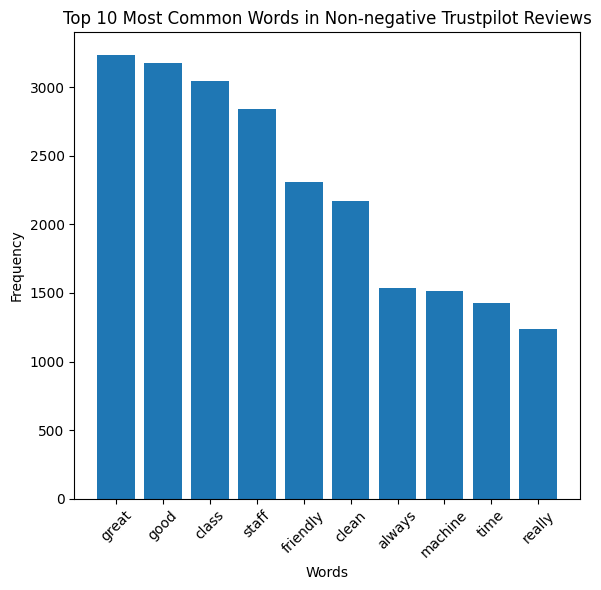

Saved non-negative frequency plot to: C:\Users\joshu\Desktop\Final Assignment\PureGym-NLP-UDA\output\plots\02_eda_and_split_negative_review_data\trustpilot_non_negative_top10_words.png


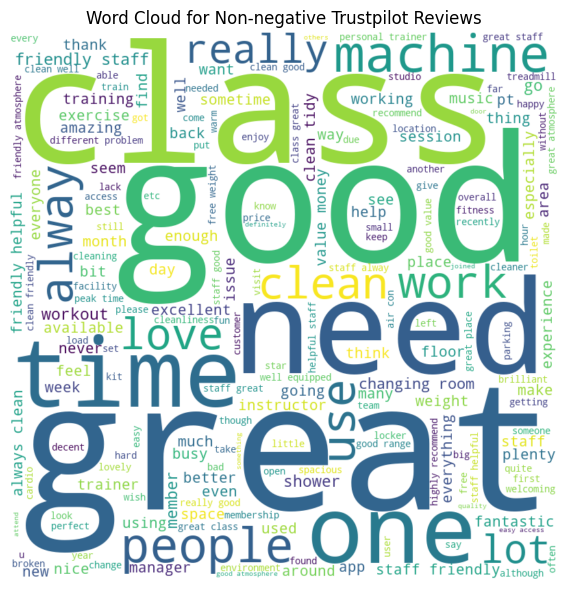

Saved non-negative wordcloud to: C:\Users\joshu\Desktop\Final Assignment\PureGym-NLP-UDA\output\plots\02_eda_and_split_negative_review_data\trustpilot_non_negative_wordcloud.png
Saved non-negative top words table to: C:\Users\joshu\Desktop\Final Assignment\PureGym-NLP-UDA\output\tables\02_eda_and_split_negative_review_data\trustpilot_non_negative_top10_words.csv


In [56]:
tokens_non_negative = (
    df_non_negative[TEXT_COL]
    .dropna()
    .astype(str)
    .str.split()
    .explode()
)

token_counts_non_negative = Counter(tokens_non_negative)
common_words_non_negative = token_counts_non_negative.most_common(TOP_N)

# Save top words table
df_top_words_non_negative = pd.DataFrame(common_words_non_negative, columns=["word", "count"])
df_top_words_non_negative.to_csv(TABLE_DIR / "trustpilot_non_negative_top10_words.csv", index=False)

words_non_neg, counts_non_neg = zip(*common_words_non_negative) if common_words_non_negative else ([], [])

freq_plot_path_non_negative = plotter.plot_word_frequencies(
    words=words_non_neg,
    counts=counts_non_neg,
    title="Top 10 Most Common Words in Non-negative Trustpilot Reviews",
    filename="trustpilot_non_negative_top10_words.png",
)

print(f"Saved non-negative frequency plot to: {freq_plot_path_non_negative}")

wordcloud_path_non_negative = plotter.plot_wordcloud(
    tokens=tokens_non_negative,
    title="Word Cloud for Non-negative Trustpilot Reviews",
    filename="trustpilot_non_negative_wordcloud.png",
    seed=SEED,
)

print(f"Saved non-negative wordcloud to: {wordcloud_path_non_negative}")
print(f"Saved non-negative top words table to: {TABLE_DIR / 'trustpilot_non_negative_top10_words.csv'}")

In [57]:
elapsed_s = time.perf_counter() - NOTEBOOK_T0
elapsed_m = elapsed_s / 60

print(f"\nTotal runtime: {elapsed_s:,.1f} seconds ({elapsed_m:,.2f} minutes)")


Total runtime: 8.8 seconds (0.15 minutes)


# 03_topic_modelling_bertopic

This section applies BERTopic topic modelling to:

- Negative reviews

UMAP is used for dimensionality reduction and visualisation, and summary tables and plots are saved for reporting.

**Outputs:**

- Models: `output/models/03_topic_modelling_bertopic/`

- Tables: `output/tables/03_topic_modelling_bertopic/`

- Plots: `output/plots/03_topic_modelling_bertopic/`

**Compute and reproducibility:** CPU-only local execution, fixed random seed **901**.


In [58]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [59]:
NOTEBOOK_T0 = time.perf_counter()
print("Notebook timer started.")

Notebook timer started.


In [60]:
# BERTopic Runner
from modelling.bertopic.bertopic_runner import BERTopicRunner

In [61]:
DATA_DIR = (PROJECT_ROOT / CONFIG["DATA"]["DATA_DIR"])
DATA_DIR.mkdir(parents=True, exist_ok=True)

PREPROCESSED_FILENAME = CONFIG["DATA"]["PREPROCESSED_FILENAME"]
PREPROCESSED_PATH = f"{DATA_DIR}/{PREPROCESSED_FILENAME}"

TEXT_COL = CONFIG["FILTERING"]["TEXT_COL"]
NEGATIVE_RATINGS = ast.literal_eval(CONFIG["FILTERING"].get("NEGATIVE_RATINGS", "[]"))
SEED = CONFIG["REPRODUCIBILITY"].getint("SEED")

PLOT_DIR = PROJECT_ROOT / CONFIG["OUTPUT"]["PLOT_DIR"] / "03_topic_modelling_bertopic"
TABLE_DIR = PROJECT_ROOT / CONFIG["OUTPUT"]["TABLE_DIR"] / "03_topic_modelling_bertopic"
MODEL_DIR = PROJECT_ROOT / CONFIG["OUTPUT"]["MODEL_DIR"] / "03_topic_modelling_bertopic"

In [62]:
TOP_N_TOPICS = 4
N_WORDS_BARCHART = 5
SHOW_PLOTS = True
SAVE_PNG = True
PNG_SCALE = 2

UMAP_N_NEIGHBOURS = 15
UMAP_N_COMPONENTS = 5
UMAP_MIN_DIST = 0
UMAP_METRIC = "cosine"

In [63]:
df = load_csv(PREPROCESSED_PATH)
df_negative = df[df["Rating"].isin(NEGATIVE_RATINGS)].copy()
df_non_negative = df[~df["Rating"].isin(NEGATIVE_RATINGS)].copy()

In [64]:
runner = BERTopicRunner(
    model_dir=MODEL_DIR,
    plot_dir=PLOT_DIR,
    table_dir=TABLE_DIR,
    seed=SEED,
    min_topic_size=40,

    # Topic-level controls
    top_n_topics=TOP_N_TOPICS,
    n_words_barchart=N_WORDS_BARCHART,

    # Plotting controls
    show_plots=SHOW_PLOTS,
    save_png=SAVE_PNG,
    png_scale=PNG_SCALE,

    # UMAP controls
    umap_n_neighbors=UMAP_N_NEIGHBOURS,
    umap_n_components=UMAP_N_COMPONENTS,
    umap_min_dist=UMAP_MIN_DIST,
    umap_metric=UMAP_METRIC,
)

In [65]:
neg_result = runner.run(df_negative, label="negative", text_col=TEXT_COL, verbose=True)
print(neg_result.plot_paths)
display(neg_result.topic_info.head(3))
display(neg_result.top_topics_table.head(5))

2026-01-21 04:12:02,406 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 74/74 [00:12<00:00,  5.80it/s]
2026-01-21 04:12:17,308 - BERTopic - Embedding - Completed ✓
2026-01-21 04:12:17,309 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-21 04:12:34,361 - BERTopic - Dimensionality - Completed ✓
2026-01-21 04:12:34,363 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-21 04:12:34,452 - BERTopic - Cluster - Completed ✓
2026-01-21 04:12:34,455 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-21 04:12:34,532 - BERTopic - Representation - Completed ✓
2026-01-21 04:12:34,599 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


{'intertopic_distance_html': WindowsPath('C:/Users/joshu/Desktop/Final Assignment/PureGym-NLP-UDA/output/plots/03_topic_modelling_bertopic/bertopic_negative_intertopic_distance.html'), 'intertopic_distance_png': WindowsPath('C:/Users/joshu/Desktop/Final Assignment/PureGym-NLP-UDA/output/plots/03_topic_modelling_bertopic/bertopic_negative_intertopic_distance.png'), 'barchart_top_topics_html': WindowsPath('C:/Users/joshu/Desktop/Final Assignment/PureGym-NLP-UDA/output/plots/03_topic_modelling_bertopic/bertopic_negative_barchart_top4.html'), 'barchart_top_topics_png': WindowsPath('C:/Users/joshu/Desktop/Final Assignment/PureGym-NLP-UDA/output/plots/03_topic_modelling_bertopic/bertopic_negative_barchart_top4.png'), 'heatmap_all_topics_html': WindowsPath('C:/Users/joshu/Desktop/Final Assignment/PureGym-NLP-UDA/output/plots/03_topic_modelling_bertopic/bertopic_negative_heatmap_all_topics.html'), 'heatmap_all_topics_png': WindowsPath('C:/Users/joshu/Desktop/Final Assignment/PureGym-NLP-UDA/ou

,Topic,Count,Name,Representation,Representative_Docs
0,-1,725,-1_machine_time_people_staff,"[machine, time, people, staff, member, one, get, would, use, like]","[hi happy actually time remodelling supposed get better came back couple month work finished machine also working take long time routine work also need make time another exercise pay money work machine working one many people disappointed please would love manager resolve problem, member almost year happily even upgraded premium membership well last year hired pt feel like confidently say rat go frequently friend family tell many time various deal would offer value money better price different pt proven result month year good decided stay loyal point managed convince various friend mine come also past year year workout past month however feel like let drastically loyalty nothing whole time member stuck payment time without asking kind favour making kind complaint week ago made known would struggle first time due recent cost living payment going delayed hour pay check came tried ask could done make sure either charged extra penalised imagine disappointment bluntly told would help granted regard situation without attempt solution choice cancel membership make sure could get last month without incurring extra charge since found another signed assumed would end saga past week apparently case still pay one last month pt despite completely different care compensated fund anybody finally deem necessary made perfectly clear recent day financial situation taken seriously neither customer long time loyal member treated going back hope nobody else go disappointment betrayal trust loyalty either, two year going got worse time getting better looking new go promise wifi never happened never got two year yet staff issue getting online wifi proper climate control main air con broken last two year instead fixing try using portable unit job summer hot winter hot water temp set cold shower shower sink drainage stink get blocked time drain need sorting fixing see machine action one machine issue people routine flavour water dispenser seems run flavour time order damaged flooring stuck tape silly stuff like charge make promise thing deliver literally falling apart seems company management care pay give offer take care repair like meant friendly staff lot nice people go even though lot stopped going see reason go]"
1,0,521,0_shower_toilet_room_dirty,"[shower, toilet, room, dirty, changing, cleaning, water, cold, clean, machine]","[luke warm best often cold shower said national change lower temperature save cost often grotty shower changing area changing area specific small get dirty quickly maintained recently starting break item begining show age large part year year one working toilet hand dryer work replaced paper towel people began throw everywhere fault cleaned well often left changing room mess issue occur hand dryer broken long period big plus helpful friendly staff used love member month year decided move cold shower long session final straw, nice space good atmosphere however machine quite old cardio machine broken day maybe week shower luke warm past month even cold weather last time yesterday water completely cold understand energy bill astronomical day fair user expect hot shower working least think people also instance even notice saying shower cold undress get bit go shower press bottom four time hoping get warm turn around get dressed go shower home, ok nothing special like staff nice work well clean need loo toilet spacious shower look good several hand dryer working week go area get paper towel dripping water go dangerous main thing toilet unisex men woman thats woman use disgusting men spray everywhere using go find smelly urine floor toilet seat make turn around walk refuse use know get cleaned regularly huge thing able use loo apart ok purgym please put lady toilet get full mark honest opinion thanks reply reply looking basic email get sent everyone ask put lady toilet o

,Topic,Count,TopWords
0,0,521,"shower, toilet, room, dirty, changing, cleaning, water, cold, clean, machine"
1,1,337,"membership, email, cancel, customer, service, account, month, app, money, payment"
2,2,211,"machine, weight, bench, space, one, cardio, need, area, get, enough"
3,3,140,"class, instructor, cancelled, booked, spin, book, booking, time, one, get"


In [66]:
elapsed_s = time.perf_counter() - NOTEBOOK_T0
elapsed_m = elapsed_s / 60

print(f"\nTotal runtime: {elapsed_s:,.1f} seconds ({elapsed_m:,.2f} minutes)")


Total runtime: 73.7 seconds (1.23 minutes)


# 04a_emotion_analysis_roberta

This section performs transformer-based emotion classification using a DistilRoBERTa emotion model:

- Runs token-length diagnostics to inform a conservative `max_length` choice.

- Performs batched inference to assign a dominant emotion label and confidence score to each review.

- Splits emotion-annotated data into negative and non-negative subsets.

- Produces emotion distribution tables and bar plots for all, negative, and non-negative reviews.

**Outputs (data/):**
- `PureGym Customer Reviews_preprocessed_emotion.csv`

- `PureGym Customer Reviews_preprocessed_negative_emotion.csv`

- `PureGym Customer Reviews_preprocessed_non_negative_emotion.csv`

**Additional outputs:** plots and tables under `output/plots/04a_emotion_analysis/` and `output/tables/04a_emotion_analysis/`.

**Compute and reproducibility:** CPU-only local execution, fixed random seed **901**.


### Emotion Classes

In [67]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
class Initialiser:
    """Initialise tokenizer and model for emotion sequence classification."""

    @staticmethod
    def init_tokenizer(model_name: str) -> AutoTokenizer:
        return AutoTokenizer.from_pretrained(model_name)

    @staticmethod
    def init_model(model_name: str) -> AutoModelForSequenceClassification:
        return AutoModelForSequenceClassification.from_pretrained(model_name)




In [68]:
from dataclasses import dataclass


@dataclass(frozen=True)
class EmotionParams:
    """
    Central config for the emotion classification model run.
    """

    MODEL_NAME_V1: str = "j-hartmann/emotion-english-distilroberta-base"
    MODEL_NAME_V2: str = "bhadresh-savani/bert-base-uncased-emotion"

    DEVICE: str = "cpu"

    BATCH_SIZE: int = 16
    MAX_LENGTH: int = 192

    PADDING: bool = True
    TRUNCATION: bool = True

    LABEL_COL: str = "Dominant Emotion"
    SCORE_COL: str = "Confidence Score"



In [69]:
from typing import Tuple, Any

import pandas as pd
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer


class EmotionModelDataCompiler:
    """
    Apply a Hugging Face emotion sequence classification model to a DataFrame text column.

    The compiler tokenises text in batches, runs the model in inference mode, and
    appends two columns to the returned DataFrame:
    - predicted label (string)
    - confidence score (float, max softmax probability)

    Parameters
    ----------
    df
        Input DataFrame containing the text to classify.
    text_col
        Name of the column in ``df`` containing the text.
    tokenizer
        Hugging Face tokenizer used to encode text.
    model
        Hugging Face sequence classification model.
    device
        Torch device string, for example "cpu" or "cuda".
    batch_size
        Number of texts per inference batch.
    max_length
        Maximum token length for truncation.
    label_col
        Output column name for predicted labels.
    score_col
        Output column name for confidence scores.
    padding
        Whether to pad sequences in a batch (passed to the tokenizer).
    truncation
        Whether to truncate sequences to ``max_length`` (passed to the tokenizer).
    """

    def __init__(
        self,
        *,
        df: pd.DataFrame,
        text_col: str,
        tokenizer: AutoTokenizer,
        model: AutoModelForSequenceClassification,
        device: str,
        batch_size: int,
        max_length: int,
        label_col: str,
        score_col: str,
        padding: bool,
        truncation: bool,
    ) -> None:

        if text_col not in df.columns:
            raise KeyError(f"'{text_col}' not found in DataFrame")

        # Store core inputs for later use
        self._df = df
        self._text_col = text_col

        self._tokenizer = tokenizer
        self._model = model
        self._device = torch.device(device)

        # Store inference settings (batching + tokenisation behaviour)
        self._batch_size = batch_size
        self._max_length = max_length
        self._padding = padding
        self._truncation = truncation

        # Store output column names
        self._label_col = label_col
        self._score_col = score_col

        # Ensure model is on the correct device and set to inference mode
        self._model.to(self._device)
        self._model.eval()

        # Map numeric class ids to human-readable labels (falls back to id if missing)
        id2label = getattr(self._model.config, "id2label", None) or {}
        self._id2label = {int(k): str(v) for k, v in id2label.items()}

    def apply(self) -> pd.DataFrame:
        """
        Run inference over the configured DataFrame and append label and score columns.

        Returns
        -------
        pandas.DataFrame
            Copy of the input DataFrame with two additional columns.
        """

        df_out = self._df.copy()

        # Clean text inputs (avoid NaNs, enforce string type, remove surrounding whitespace)
        texts = (
            df_out[self._text_col]
            .fillna("")
            .astype(str)
            .str.strip()
            .tolist()
        )

        # Run model inference to obtain labels and confidence scores
        labels, scores = self._predict(texts)

        # Append outputs back onto the DataFrame in the same row order
        df_out[self._label_col] = labels
        df_out[self._score_col] = scores
        return df_out

    def _predict(self, texts: list[str]) -> Tuple[list[str], list[float]]:
        """
        Predict labels and confidence scores for a list of texts.

        Parameters
        ----------
        texts
            List of input texts.

        Returns
        -------
        tuple[list[str], list[float]]
            Predicted labels and confidence scores aligned to ``texts``.
        """
        out_labels: list[str] = []
        out_scores: list[float] = []

        # Handle empty input explicitly (keeps behaviour predictable for callers)
        if not texts:
            return out_labels, out_scores

        # Process texts in batches 
        for start in range(0, len(texts), self._batch_size):
            batch = texts[start : start + self._batch_size]

            # Tokenise the batch using the configured padding/truncation strategy
            enc = self._tokenizer(
                batch,
                padding=self._padding,
                truncation=self._truncation,
                max_length=self._max_length,
                return_tensors="pt",
            )

            # Move tokenised tensors onto the same device as the model
            enc = {k: v.to(self._device) for k, v in enc.items()}

            # Inference only: disable gradients to reduce memory and improve speed
            with torch.no_grad():
                logits = self._model(**enc).logits

            # Convert logits to probabilities, then pick the highest-probability class
            probs = torch.softmax(logits, dim=-1)
            best_scores, best_ids = torch.max(probs, dim=-1)

            # Convert tensors to plain Python types and map ids to label strings
            for label_id, score in zip(
                best_ids.detach().cpu().numpy(),
                best_scores.detach().cpu().numpy(),
            ):
                label = self._id2label.get(int(label_id), str(int(label_id)))
                out_labels.append(label)
                out_scores.append(float(score))

        return out_labels, out_scores


In [70]:
# Single helper function for bar charts
def bar_plot(
    counts: pd.Series,
    *,
    title: str,
    x_label: str,
    y_label: str,
    figsize: tuple[float, float] = (7.0, 7.0),
    rotation: int = 45,
    show: bool = True,
    save: bool = False,
    output_dir: Optional[Path] = None,
    filename: Optional[str] = None,
    dpi: int = 150,
    print_path: bool = True,
) -> None:
    """
    Plot a categorical bar chart from a frequency Series.

    Parameters
    ----------
    counts
        Counts indexed by category (x-axis labels).
    title
        Plot title.
    x_label
        X-axis label.
    y_label
        Y-axis label.
    figsize
        Figure size in inches.
    rotation
        Rotation for x tick labels.
    show
        If True, display the figure.
    save
        If True, save the figure to disk.
    output_dir
        Output directory used when ``save=True``.
    filename
        Output filename used when ``save=True``.
    dpi
        Resolution used when saving.
    print_path
        If True and ``save=True``, print the saved path.

    Returns
    -------
    None

    Raises
    ------
    ValueError
        If ``save=True`` and ``output_dir`` or ``filename`` is not provided.
    """
    fig, ax = plt.subplots(figsize=figsize)

    x = counts.index.astype(str)
    y = counts.to_numpy()
    ax.bar(x, y)

    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.tick_params(axis="x", rotation=rotation)
    fig.tight_layout()

    if save:
        if output_dir is None or filename is None:
            plt.close(fig)
            raise ValueError("When save=True, both output_dir and filename must be provided.")
        output_dir.mkdir(parents=True, exist_ok=True)
        out_path = output_dir / filename
        fig.savefig(out_path, dpi=dpi, bbox_inches="tight")
        if print_path:
            print("Saved plot to:", out_path)

    if show:
        plt.show()

    plt.close(fig)



In [71]:
NOTEBOOK_T0 = time.perf_counter()
print("Notebook timer started.")

Notebook timer started.


In [72]:
from utils.data_management.data_io import load_csv, save_csv

DATA_DIR = (PROJECT_ROOT / CONFIG["DATA"]["DATA_DIR"])
DATA_DIR.mkdir(parents=True, exist_ok=True)

PREPROCESSED_FILENAME = CONFIG["DATA"]["PREPROCESSED_FILENAME_SENTIMENT"]
PREPROCESSED_PATH = f"{DATA_DIR}/{PREPROCESSED_FILENAME}"

TEXT_COL = CONFIG["FILTERING"]["TEXT_COL"]
NEGATIVE_RATINGS = ast.literal_eval(CONFIG["FILTERING"].get("NEGATIVE_RATINGS", "[]"))
SEED = CONFIG["REPRODUCIBILITY"].getint("SEED")

PLOT_DIR = PROJECT_ROOT / CONFIG["OUTPUT"]["PLOT_DIR"] / "04a_emotion_analysis"
TABLE_DIR = PROJECT_ROOT / CONFIG["OUTPUT"]["TABLE_DIR"] / "04a_emotion_analysis"

PLOT_DIR.mkdir(parents=True, exist_ok=True)
TABLE_DIR.mkdir(parents=True, exist_ok=True)

SEED = CONFIG["REPRODUCIBILITY"].getint("SEED")

In [73]:
FIGSIZE = (7, 7)
DPI = 150

In [74]:
# Paths
preprocessed_path = Path(DATA_DIR / PREPROCESSED_FILENAME)
PREPROCESSED_PATH = str(preprocessed_path)
print("PREPROCESSED_PATH:", PREPROCESSED_PATH)

PREPROCESSED_PATH: C:\Users\joshu\Desktop\Final Assignment\PureGym-NLP-UDA\data\PureGym Customer Reviews_preprocessed_sentiment.csv


In [75]:
PREPROCESSED_FILENAME_EMOTION = CONFIG["DATA"]["PREPROCESSED_FILENAME_EMOTION"]
PREPROCESSED_FILENAME_NEGATIVE_EMOTION = CONFIG["DATA"]["PREPROCESSED_FILENAME_NEGATIVE_EMOTION"]
PREPROCESSED_FILENAME_NON_NEGATIVE_EMOTION = CONFIG["DATA"]["PREPROCESSED_FILENAME_NON_NEGATIVE_EMOTION"]

ALL_EMOTION_PATH = Path(DATA_DIR) / PREPROCESSED_FILENAME_EMOTION
NEG_EMOTION_PATH = Path(DATA_DIR) / PREPROCESSED_FILENAME_NEGATIVE_EMOTION
NON_NEG_EMOTION_PATH = Path(DATA_DIR) / PREPROCESSED_FILENAME_NON_NEGATIVE_EMOTION

print("ALL_EMOTION_PATH:", ALL_EMOTION_PATH)
print("NEG_EMOTION_PATH:", NEG_EMOTION_PATH)
print("NON_NEG_EMOTION_PATH:", NON_NEG_EMOTION_PATH)

ALL_EMOTION_PATH: C:\Users\joshu\Desktop\Final Assignment\PureGym-NLP-UDA\data\PureGym Customer Reviews_preprocessed_emotion.csv
NEG_EMOTION_PATH: C:\Users\joshu\Desktop\Final Assignment\PureGym-NLP-UDA\data\PureGym Customer Reviews_preprocessed_negative_emotion.csv
NON_NEG_EMOTION_PATH: C:\Users\joshu\Desktop\Final Assignment\PureGym-NLP-UDA\data\PureGym Customer Reviews_preprocessed_non_negative_emotion.csv


In [76]:
# Load preprocessed dataset only (single inference run)

df_all = load_csv(PREPROCESSED_PATH)
print("All reviews:", len(df_all))
display(df_all.head())

All reviews: 11300


,Rating,Date Experienced,Review Title,Review
0,4,2023-12-17,"A well equipped gym, lacked cleaning facilities",well equipped notice one machine order disappoint lack blue towel sanitizer spray customer use finish notice ask customer matter respect user
1,4,2023-12-13,Overall a good experience,overall good experience still cramp compare old redditch number seem reduce little little readily available change room far small though take look sunderland comparison one jewel crown mark fisher guy class insane nice possible way book class early avoid disappointment
2,5,2023-12-12,Excellent gym,excellent friendly environment plenty choice space exercise personal trainer hand excellent opening hour basically go whenever want 🙌 get busy time always get something class also good
3,5,2023-11-12,I'm going to be so fit,havnt member year state art brand new friendly staff really good competitive monthly price
4,5,2023-12-13,Chloe Lawrence PT at PureGym,train chloe lawrence month soon finish th month incredible push absolute maximum without aggressive intimidate inspire feel amaze coaching notice difference strength mood sleep health coaching also help create good schedule exercise make confident enough go thing never would chloe informative nutrition biology behind exercise well really feel like learn much time general chloe lovely person make effort keep priority really feel like someone corner team journey recommend highly enough


## Token Length EDA

* The max_length has been conservatively set to 192 in the EmotionParams file based on the above (see import path in cell above). This has been kept constant for emotion based models..

In [77]:
## Token Length EDA
RUN_TOKEN_LENGTH_DIAGNOSTICS = True  # set True to run diagnostics

if RUN_TOKEN_LENGTH_DIAGNOSTICS:
    MAXLEN_CANDIDATES = [64, 96, 128, 160, 192, 256, 320, 384, 448, 512]
    df_for_profile = df_all 

    texts = (df_for_profile[TEXT_COL].fillna("").astype(str).str.strip())
    texts = texts.loc[texts.ne("")]

    model_name_v1 = EmotionParams.MODEL_NAME_V1
    model_name_v2 = EmotionParams.MODEL_NAME_V2

    print(f"Tokenizer/model V1: {model_name_v1}")
    print(f"Tokenizer/model V2: {model_name_v2}")

    # Initialise both tokenisers based on model names
    tokenizer_v1 = Initialiser.init_tokenizer(model_name_v1)
    tokenizer_v2 = Initialiser.init_tokenizer(model_name_v2)

    # Compute token lengths without truncation for each tokeniser
    token_lengths_v1 = texts.apply(lambda t: len(tokenizer_v1.encode(t, add_special_tokens=True))).to_numpy()
    token_lengths_v2 = texts.apply(lambda t: len(tokenizer_v2.encode(t, add_special_tokens=True))).to_numpy()

    # Worst-case length per text across both tokenisers (safe choice for later max_length)
    token_lengths_worst = np.maximum(token_lengths_v1, token_lengths_v2)

    # % fully captured for each candidate max length
    captured_pct_v1 = [(token_lengths_v1 <= L).mean() * 100 for L in MAXLEN_CANDIDATES]
    captured_pct_v2 = [(token_lengths_v2 <= L).mean() * 100 for L in MAXLEN_CANDIDATES]
    captured_pct_worst = [(token_lengths_worst <= L).mean() * 100 for L in MAXLEN_CANDIDATES]

    # Summary stats
    percentiles = [50, 75, 90, 95, 97, 99]
    pvals_v1 = np.percentile(token_lengths_v1, percentiles)
    pvals_v2 = np.percentile(token_lengths_v2, percentiles)

    p99_v1 = float(np.percentile(token_lengths_v1, 99))
    p99_v2 = float(np.percentile(token_lengths_v2, 99))
    p99_max = max(p99_v1, p99_v2)

    print("Token length percentiles (V1):")
    for p, v in zip(percentiles, pvals_v1):
        print(f"{p:>2}%: {int(v)} tokens")

    print("\nToken length percentiles (V2):")
    for p, v in zip(percentiles, pvals_v2):
        print(f"{p:>2}%: {int(v)} tokens")

    print(f"\n99th percentile (V1): {int(p99_v1)} tokens")
    print(f"99th percentile (V2): {int(p99_v2)} tokens")
    print(f"Using larger 99th percentile across V1/V2: {int(p99_max)} tokens")

    print("\nCapture by candidate max_length (%):")
    for L, p1, p2, pw in zip(MAXLEN_CANDIDATES, captured_pct_v1, captured_pct_v2, captured_pct_worst):
        print(f"{L:>3}: V1={p1:6.2f}% | V2={p2:6.2f}% | worst-case={pw:6.2f}%")

    best_L = next((L for L, p in zip(MAXLEN_CANDIDATES, captured_pct_worst) if p >= 99), None)
    if best_L is not None:
        print(f"\nFirst candidate max_length capturing ≥99% for BOTH tokenisers (worst-case): {best_L}.")
    else:
        print("\nNo candidate max_length reached 99% capture for BOTH tokenisers (consider adding larger values).")

Tokenizer/model V1: j-hartmann/emotion-english-distilroberta-base
Tokenizer/model V2: bhadresh-savani/bert-base-uncased-emotion
Token length percentiles (V1):
50%: 16 tokens
75%: 28 tokens
90%: 49 tokens
95%: 68 tokens
97%: 83 tokens
99%: 126 tokens

Token length percentiles (V2):
50%: 16 tokens
75%: 28 tokens
90%: 49 tokens
95%: 68 tokens
97%: 84 tokens
99%: 127 tokens

99th percentile (V1): 126 tokens
99th percentile (V2): 127 tokens
Using larger 99th percentile across V1/V2: 127 tokens

Capture by candidate max_length (%):
 64: V1= 94.24% | V2= 94.19% | worst-case= 94.00%
 96: V1= 97.91% | V2= 97.89% | worst-case= 97.84%
128: V1= 99.07% | V2= 99.02% | worst-case= 99.00%
160: V1= 99.50% | V2= 99.46% | worst-case= 99.45%
192: V1= 99.65% | V2= 99.65% | worst-case= 99.65%
256: V1= 99.87% | V2= 99.85% | worst-case= 99.85%
320: V1= 99.93% | V2= 99.93% | worst-case= 99.93%
384: V1= 99.96% | V2= 99.96% | worst-case= 99.96%
448: V1= 99.97% | V2= 99.97% | worst-case= 99.97%
512: V1=100.00% | 

In [78]:
tokenizer = Initialiser.init_tokenizer(EmotionParams.MODEL_NAME_V1)
model = Initialiser.init_model(EmotionParams.MODEL_NAME_V1)

compiler = EmotionModelDataCompiler(
    df=df_all,
    text_col=TEXT_COL,
    tokenizer=tokenizer,
    model=model,
    device=EmotionParams.DEVICE,
    batch_size=EmotionParams.BATCH_SIZE,
    max_length=EmotionParams.MAX_LENGTH,
    label_col=EmotionParams.LABEL_COL,
    score_col=EmotionParams.SCORE_COL,
    padding=EmotionParams.PADDING,
    truncation=EmotionParams.TRUNCATION,
)

In [79]:
MODEL_TAG = re.sub(r"[^A-Za-z0-9]+", "_", EmotionParams.MODEL_NAME_V1).strip("_")

# Print params 
print("\nEmotionParams used:")
print("MODEL_NAME:", EmotionParams.MODEL_NAME_V1)
print("DEVICE:", EmotionParams.DEVICE)
print("BATCH_SIZE:", EmotionParams.BATCH_SIZE)
print("MAX_LENGTH:", EmotionParams.MAX_LENGTH)
print("PADDING:", EmotionParams.PADDING)
print("TRUNCATION:", EmotionParams.TRUNCATION)
print("LABEL_COL:", EmotionParams.LABEL_COL)
print("SCORE_COL:", EmotionParams.SCORE_COL)
print("TEXT_COL:", TEXT_COL)
print("Rows:", len(df_all))

print("Tokenizer class:", type(tokenizer).__name__)
print("Is fast tokenizer:", getattr(tokenizer, "is_fast", False))
print("Vocab size:", tokenizer.vocab_size)
print("Model max length:", tokenizer.model_max_length)
print("Pad token:", tokenizer.pad_token, tokenizer.pad_token_id)
print("EOS token:", tokenizer.eos_token, tokenizer.eos_token_id)



EmotionParams used:
MODEL_NAME: j-hartmann/emotion-english-distilroberta-base
DEVICE: cpu
BATCH_SIZE: 16
MAX_LENGTH: 192
PADDING: True
TRUNCATION: True
LABEL_COL: Dominant Emotion
SCORE_COL: Confidence Score
TEXT_COL: Review
Rows: 11300
Tokenizer class: RobertaTokenizerFast
Is fast tokenizer: True
Vocab size: 50265
Model max length: 512
Pad token: <pad> 1
EOS token: </s> 2


In [80]:
# Apply: All reviews (single inference run)
df_all_emotion = compiler.apply()

display(df_all_emotion[[TEXT_COL, EmotionParams.LABEL_COL, EmotionParams.SCORE_COL]].head(4))

all_save_path = save_csv(df_all_emotion, f"{DATA_DIR}/{PREPROCESSED_FILENAME_EMOTION}", suffix=None)
print(f"Saved emotion-annotated all reviews to: {all_save_path}")

,Review,Dominant Emotion,Confidence Score
0,well equipped notice one machine order disappoint lack blue towel sanitizer spray customer use finish notice ask customer matter respect user,neutral,0.340861
1,overall good experience still cramp compare old redditch number seem reduce little little readily available change room far small though take look sunderland comparison one jewel crown mark fisher guy class insane nice possible way book class early avoid disappointment,sadness,0.545070
2,excellent friendly environment plenty choice space exercise personal trainer hand excellent opening hour basically go whenever want 🙌 get busy time always get something class also good,joy,0.895917
3,havnt member year state art brand new friendly staff really good competitive monthly price,joy,0.539193


Saved emotion-annotated all reviews to: C:\Users\joshu\Desktop\Final Assignment\PureGym-NLP-UDA\data\PureGym Customer Reviews_preprocessed_emotion.csv


In [81]:
# Split from annotated dataset 
df_negative_emotion = df_all_emotion[df_all_emotion["Rating"].isin(NEGATIVE_RATINGS)].copy()
df_non_negative_emotion = df_all_emotion[~df_all_emotion["Rating"].isin(NEGATIVE_RATINGS)].copy()

print("Negative reviews:", len(df_negative_emotion))
print("Non-negative reviews:", len(df_non_negative_emotion))

display(df_negative_emotion[[TEXT_COL, EmotionParams.LABEL_COL, EmotionParams.SCORE_COL]].head(4))
display(df_non_negative_emotion[[TEXT_COL, EmotionParams.LABEL_COL, EmotionParams.SCORE_COL]].head(4))

neg_save_path = save_csv(df_negative_emotion, f"{DATA_DIR}/{PREPROCESSED_FILENAME_NEGATIVE_EMOTION}", suffix=None)
print(f"Saved emotion-annotated negative reviews to: {neg_save_path}")

non_neg_save_path = save_csv(df_non_negative_emotion, PREPROCESSED_PATH, suffix="_non_negative_emotion")
non_neg_save_path = save_csv(df_non_negative_emotion, f"{DATA_DIR}/{PREPROCESSED_FILENAME_NON_NEGATIVE_EMOTION}", suffix=None)

Negative reviews: 2368
Non-negative reviews: 8932


,Review,Dominant Emotion,Confidence Score
10,historically upkeep machine facility slow ok last month men shower lukewarm best know member notice pay membership every month cold shower good enough let worry carbon footprint cost go increase membership fee,sadness,0.536305
16,joined local zero join fee except local exempt charge £ join fee ready train festive period local close festive period due staff shortage company thay adverises day access yet access want close make sence policy place manager abuse futher conversion manager team stay u conversion transcript share staff,sadness,0.570132
17,almost week shut still receive single email update proceed go like finsbury park near one hence join local seven sister one keep come check open every day absolutely commitment keep u loop maintenance carry try solve problem make think catch £ first month offer want u cancel membership go £ month,sadness,0.600496
21,dirty almost never cleaning staff enforce use towel bench full sweat hair gel handwash toilet urine excrement toilet time,disgust,0.943677


,Review,Dominant Emotion,Confidence Score
0,well equipped notice one machine order disappoint lack blue towel sanitizer spray customer use finish notice ask customer matter respect user,neutral,0.340861
1,overall good experience still cramp compare old redditch number seem reduce little little readily available change room far small though take look sunderland comparison one jewel crown mark fisher guy class insane nice possible way book class early avoid disappointment,sadness,0.545070
2,excellent friendly environment plenty choice space exercise personal trainer hand excellent opening hour basically go whenever want 🙌 get busy time always get something class also good,joy,0.895917
3,havnt member year state art brand new friendly staff really good competitive monthly price,joy,0.539193


Saved emotion-annotated negative reviews to: C:\Users\joshu\Desktop\Final Assignment\PureGym-NLP-UDA\data\PureGym Customer Reviews_preprocessed_negative_emotion.csv


,Emotion,Count
0,joy,4289
1,neutral,3691
2,sadness,1458
3,fear,554
4,surprise,490
5,anger,477
6,disgust,341


Saved table to: C:\Users\joshu\Desktop\Final Assignment\PureGym-NLP-UDA\output\tables\04a_emotion_analysis\emotion_counts_all_reviews_j_hartmann_emotion_english_distilroberta_base.csv
Saved plot to: C:\Users\joshu\Desktop\Final Assignment\PureGym-NLP-UDA\output\plots\04a_emotion_analysis\emotion_distribution_all_reviews_j_hartmann_emotion_english_distilroberta_base.png


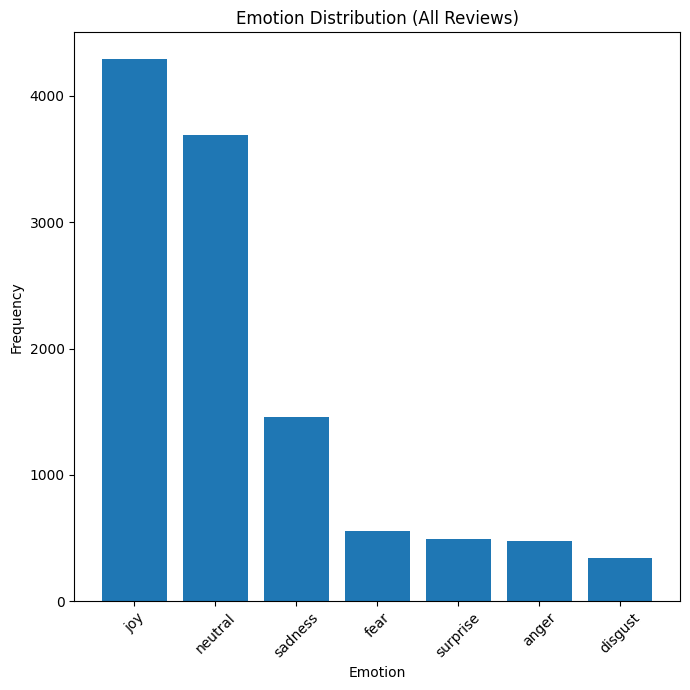

In [82]:
# Tables and Plots: All reviews
counts_all = df_all_emotion[EmotionParams.LABEL_COL].value_counts(dropna=False)
counts_all_df = counts_all.rename_axis("Emotion").reset_index(name="Count")
display(counts_all_df)

out_path = TABLE_DIR / f"emotion_counts_all_reviews_{MODEL_TAG}.csv"
counts_all_df.to_csv(out_path, index=False)
print("Saved table to:", out_path)

bar_plot(
    counts_all,
    title="Emotion Distribution (All Reviews)",
    x_label="Emotion",
    y_label="Frequency",
    figsize=FIGSIZE,
    show=True,
    save=True,
    output_dir=PLOT_DIR,
    filename=f"emotion_distribution_all_reviews_{MODEL_TAG}.png",
    dpi=DPI,
)


,Emotion,Count
0,sadness,712
1,neutral,604
2,anger,271
3,fear,243
4,disgust,205
5,surprise,183
6,joy,150


Saved table to: C:\Users\joshu\Desktop\Final Assignment\PureGym-NLP-UDA\output\tables\04a_emotion_analysis\emotion_counts_negative_reviews_j_hartmann_emotion_english_distilroberta_base.csv
Saved plot to: C:\Users\joshu\Desktop\Final Assignment\PureGym-NLP-UDA\output\plots\04a_emotion_analysis\emotion_distribution_negative_reviews_j_hartmann_emotion_english_distilroberta_base.png


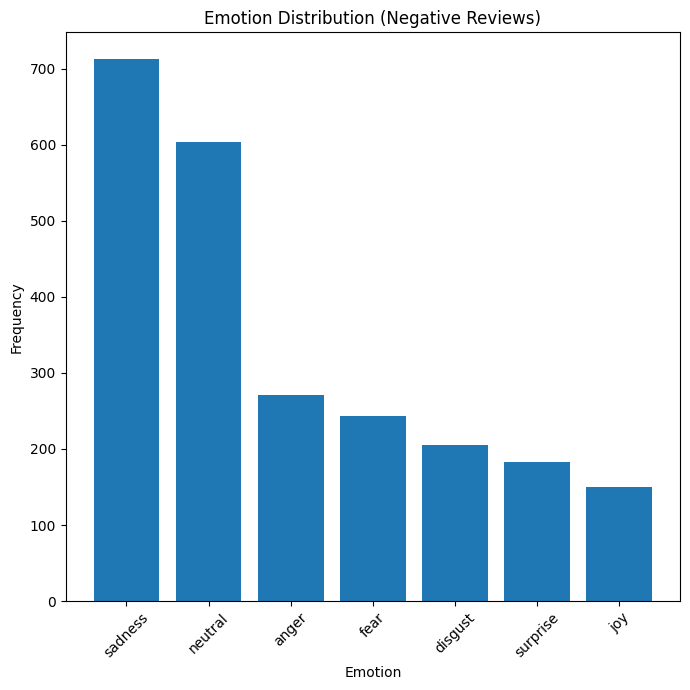

In [83]:
# Tables and Plots: Negative reviews
counts_neg = df_negative_emotion[EmotionParams.LABEL_COL].value_counts(dropna=False)
counts_neg_df = counts_neg.rename_axis("Emotion").reset_index(name="Count")
display(counts_neg_df)

out_path = TABLE_DIR / f"emotion_counts_negative_reviews_{MODEL_TAG}.csv"
counts_neg_df.to_csv(out_path, index=False)
print("Saved table to:", out_path)

bar_plot(
    counts_neg,
    title="Emotion Distribution (Negative Reviews)",
    x_label="Emotion",
    y_label="Frequency",
    figsize=FIGSIZE,
    show=True,
    save=True,
    output_dir=PLOT_DIR,
    filename=f"emotion_distribution_negative_reviews_{MODEL_TAG}.png",
    dpi=DPI,
)


,Emotion,Count
0,joy,4139
1,neutral,3087
2,sadness,746
3,fear,311
4,surprise,307
5,anger,206
6,disgust,136


Saved table to: C:\Users\joshu\Desktop\Final Assignment\PureGym-NLP-UDA\output\tables\04a_emotion_analysis\emotion_counts_non_negative_reviews_j_hartmann_emotion_english_distilroberta_base.csv
Saved plot to: C:\Users\joshu\Desktop\Final Assignment\PureGym-NLP-UDA\output\plots\04a_emotion_analysis\emotion_distribution_non_negative_reviews_j_hartmann_emotion_english_distilroberta_base.png


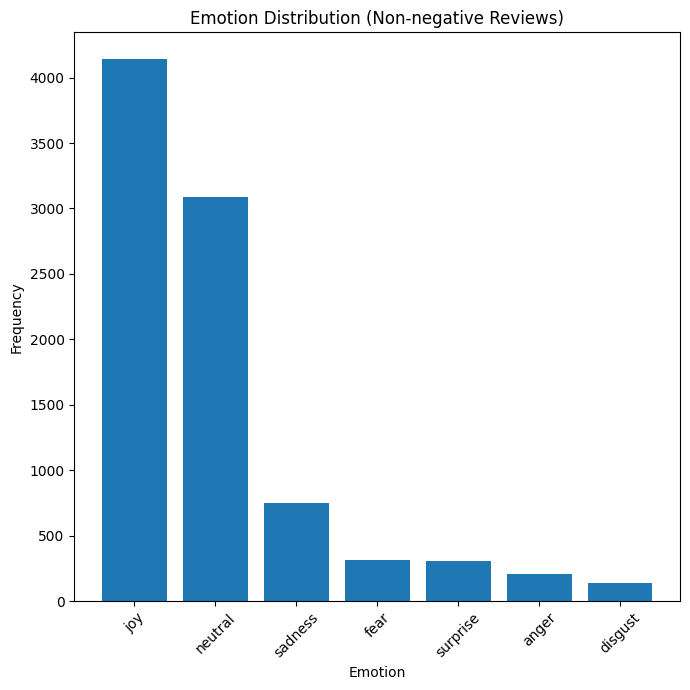

In [84]:
# Tables and Plots: Non-negative reviews
counts_non_neg = df_non_negative_emotion[EmotionParams.LABEL_COL].value_counts(dropna=False)
counts_non_neg_df = counts_non_neg.rename_axis("Emotion").reset_index(name="Count")
display(counts_non_neg_df)

out_path = TABLE_DIR / f"emotion_counts_non_negative_reviews_{MODEL_TAG}.csv"
counts_non_neg_df.to_csv(out_path, index=False)
print("Saved table to:", out_path)

bar_plot(
    counts_non_neg,
    title="Emotion Distribution (Non-negative Reviews)",
    x_label="Emotion",
    y_label="Frequency",
    figsize=FIGSIZE,
    show=True,
    save=True,
    output_dir=PLOT_DIR,
    filename=f"emotion_distribution_non_negative_reviews_{MODEL_TAG}.png",
    dpi=DPI,
)


In [85]:
elapsed_s = time.perf_counter() - NOTEBOOK_T0
elapsed_m = elapsed_s / 60

print(f"\nTotal runtime: {elapsed_s:,.1f} seconds ({elapsed_m:,.2f} minutes)")


Total runtime: 395.3 seconds (6.59 minutes)


# 04b_emotion_analysis_bert_base_uncased

This section repeats emotion classification with a second model (BERT base uncased emotion) to support model comparison:

- Runs batched inference to assign a dominant emotion label and confidence score.

- Splits results into negative and non-negative subsets.

- Produces summary tables and bar plots for all, negative, and non-negative reviews.

**Outputs:** plots and summary tables under `output/plots/04b_emotion_analysis/` and `output/tables/04b_emotion_analysis/`.

**Compute and reproducibility:** CPU-only local execution, fixed random seed **901**.


In [86]:
import time

NOTEBOOK_T0 = time.perf_counter()
print("Notebook timer started.")

Notebook timer started.


In [87]:
PLOT_DIR = PROJECT_ROOT / CONFIG["OUTPUT"]["PLOT_DIR"] / "04b_emotion_analysis"
TABLE_DIR = PROJECT_ROOT / CONFIG["OUTPUT"]["TABLE_DIR"] / "04b_emotion_analysis"

PLOT_DIR.mkdir(parents=True, exist_ok=True)
TABLE_DIR.mkdir(parents=True, exist_ok=True)

In [88]:
FIGSIZE = (7, 7)
DPI = 150

In [89]:
# Paths
preprocessed_path = Path(DATA_DIR / PREPROCESSED_FILENAME)
PREPROCESSED_PATH = str(preprocessed_path)
print("PREPROCESSED_PATH:", PREPROCESSED_PATH)

PREPROCESSED_PATH: C:\Users\joshu\Desktop\Final Assignment\PureGym-NLP-UDA\data\PureGym Customer Reviews_preprocessed_sentiment.csv


In [90]:
PREPROCESSED_FILENAME_EMOTION = CONFIG["DATA"]["PREPROCESSED_FILENAME_EMOTION"]
PREPROCESSED_FILENAME_NEGATIVE_EMOTION = CONFIG["DATA"]["PREPROCESSED_FILENAME_NEGATIVE_EMOTION"]
PREPROCESSED_FILENAME_NON_NEGATIVE_EMOTION = CONFIG["DATA"]["PREPROCESSED_FILENAME_NON_NEGATIVE_EMOTION"]

ALL_EMOTION_PATH = Path(DATA_DIR) / PREPROCESSED_FILENAME_EMOTION
NEG_EMOTION_PATH = Path(DATA_DIR) / PREPROCESSED_FILENAME_NEGATIVE_EMOTION
NON_NEG_EMOTION_PATH = Path(DATA_DIR) / PREPROCESSED_FILENAME_NON_NEGATIVE_EMOTION

print("ALL_EMOTION_PATH:", ALL_EMOTION_PATH)
print("NEG_EMOTION_PATH:", NEG_EMOTION_PATH)
print("NON_NEG_EMOTION_PATH:", NON_NEG_EMOTION_PATH)

ALL_EMOTION_PATH: C:\Users\joshu\Desktop\Final Assignment\PureGym-NLP-UDA\data\PureGym Customer Reviews_preprocessed_emotion.csv
NEG_EMOTION_PATH: C:\Users\joshu\Desktop\Final Assignment\PureGym-NLP-UDA\data\PureGym Customer Reviews_preprocessed_negative_emotion.csv
NON_NEG_EMOTION_PATH: C:\Users\joshu\Desktop\Final Assignment\PureGym-NLP-UDA\data\PureGym Customer Reviews_preprocessed_non_negative_emotion.csv


In [ ]:
# Load preprocessed dataset only (single inference run)

df_all = load_csv(PREPROCESSED_PATH)
print("All reviews:", len(df_all))
display(df_all.head(4))

All reviews: 11300


,Rating,Date Experienced,Review Title,Review
0,4,2023-12-17,"A well equipped gym, lacked cleaning facilities",well equipped notice one machine order disappoint lack blue towel sanitizer spray customer use finish notice ask customer matter respect user
1,4,2023-12-13,Overall a good experience,overall good experience still cramp compare old redditch number seem reduce little little readily available change room far small though take look sunderland comparison one jewel crown mark fisher guy class insane nice possible way book class early avoid disappointment
2,5,2023-12-12,Excellent gym,excellent friendly environment plenty choice space exercise personal trainer hand excellent opening hour basically go whenever want 🙌 get busy time always get something class also good
3,5,2023-11-12,I'm going to be so fit,havnt member year state art brand new friendly staff really good competitive monthly price
4,5,2023-12-13,Chloe Lawrence PT at PureGym,train chloe lawrence month soon finish th month incredible push absolute maximum without aggressive intimidate inspire feel amaze coaching notice difference strength mood sleep health coaching also help create good schedule exercise make confident enough go thing never would chloe informative nutrition biology behind exercise well really feel like learn much time general chloe lovely person make effort keep priority really feel like someone corner team journey recommend highly enough


In [92]:
tokenizer = Initialiser.init_tokenizer(EmotionParams.MODEL_NAME_V2)
model = Initialiser.init_model(EmotionParams.MODEL_NAME_V2)

compiler = EmotionModelDataCompiler(
    df=df_all,
    text_col=TEXT_COL,
    tokenizer=tokenizer,
    model=model,
    device=EmotionParams.DEVICE,
    batch_size=EmotionParams.BATCH_SIZE,
    max_length=EmotionParams.MAX_LENGTH,
    label_col=EmotionParams.LABEL_COL,
    score_col=EmotionParams.SCORE_COL,
    padding=EmotionParams.PADDING,
    truncation=EmotionParams.TRUNCATION,
)

In [93]:
MODEL_TAG = re.sub(r"[^A-Za-z0-9]+", "_", EmotionParams.MODEL_NAME_V2).strip("_")

# Print params 
print("\nEmotionParams used:")
print("MODEL_NAME:", EmotionParams.MODEL_NAME_V2)
print("DEVICE:", EmotionParams.DEVICE)
print("BATCH_SIZE:", EmotionParams.BATCH_SIZE)
print("MAX_LENGTH:", EmotionParams.MAX_LENGTH)
print("PADDING:", EmotionParams.PADDING)
print("TRUNCATION:", EmotionParams.TRUNCATION)
print("LABEL_COL:", EmotionParams.LABEL_COL)
print("SCORE_COL:", EmotionParams.SCORE_COL)
print("TEXT_COL:", TEXT_COL)
print("Rows:", len(df_all))

print("Tokenizer class:", type(tokenizer).__name__)
print("Is fast tokenizer:", getattr(tokenizer, "is_fast", False))
print("Vocab size:", tokenizer.vocab_size)
print("Model max length:", tokenizer.model_max_length)
print("Pad token:", tokenizer.pad_token, tokenizer.pad_token_id)
print("EOS token:", tokenizer.eos_token, tokenizer.eos_token_id)



EmotionParams used:
MODEL_NAME: bhadresh-savani/bert-base-uncased-emotion
DEVICE: cpu
BATCH_SIZE: 16
MAX_LENGTH: 192
PADDING: True
TRUNCATION: True
LABEL_COL: Dominant Emotion
SCORE_COL: Confidence Score
TEXT_COL: Review
Rows: 11300
Tokenizer class: BertTokenizerFast
Is fast tokenizer: True
Vocab size: 30522
Model max length: 512
Pad token: [PAD] 0
EOS token: None None


In [ ]:
# Apply: All reviews 
df_all_emotion = compiler.apply()

In [ ]:
# Split from annotated dataset 
df_negative_emotion = df_all_emotion[df_all_emotion["Rating"].isin(NEGATIVE_RATINGS)].copy()
df_non_negative_emotion = df_all_emotion[~df_all_emotion["Rating"].isin(NEGATIVE_RATINGS)].copy()

print("Negative reviews:", len(df_negative_emotion))
print("Non-negative reviews:", len(df_non_negative_emotion))

display(df_negative_emotion[[TEXT_COL, EmotionParams.LABEL_COL, EmotionParams.SCORE_COL]].head(4))
display(df_non_negative_emotion[[TEXT_COL, EmotionParams.LABEL_COL, EmotionParams.SCORE_COL]].head(4)) 

Negative reviews: 2368
Non-negative reviews: 8932


,Review,Dominant Emotion,Confidence Score
10,historically upkeep machine facility slow ok last month men shower lukewarm best know member notice pay membership every month cold shower good enough let worry carbon footprint cost go increase membership fee,anger,0.965633
16,joined local zero join fee except local exempt charge £ join fee ready train festive period local close festive period due staff shortage company thay adverises day access yet access want close make sence policy place manager abuse futher conversion manager team stay u conversion transcript share staff,joy,0.895263
17,almost week shut still receive single email update proceed go like finsbury park near one hence join local seven sister one keep come check open every day absolutely commitment keep u loop maintenance carry try solve problem make think catch £ first month offer want u cancel membership go £ month,joy,0.917807
21,dirty almost never cleaning staff enforce use towel bench full sweat hair gel handwash toilet urine excrement toilet time,anger,0.741413


,Review,Dominant Emotion,Confidence Score
0,well equipped notice one machine order disappoint lack blue towel sanitizer spray customer use finish notice ask customer matter respect user,joy,0.970297
1,overall good experience still cramp compare old redditch number seem reduce little little readily available change room far small though take look sunderland comparison one jewel crown mark fisher guy class insane nice possible way book class early avoid disappointment,joy,0.850009
2,excellent friendly environment plenty choice space exercise personal trainer hand excellent opening hour basically go whenever want 🙌 get busy time always get something class also good,joy,0.995373
3,havnt member year state art brand new friendly staff really good competitive monthly price,joy,0.998229


,Emotion,Count
0,joy,8163
1,anger,1402
2,sadness,1027
3,love,356
4,fear,287
5,surprise,65


Saved table to: /Users/Joshua.Dixon/Documents/8_uni/8 Unstructured Data Analysis/Assignment 2/output/tables/04b_emotion_analysis/emotion_counts_all_reviews_bhadresh_savani_bert_base_uncased_emotion.csv
Saved plot to: /Users/Joshua.Dixon/Documents/8_uni/8 Unstructured Data Analysis/Assignment 2/output/plots/04b_emotion_analysis/emotion_distribution_all_reviews_bhadresh_savani_bert_base_uncased_emotion.png


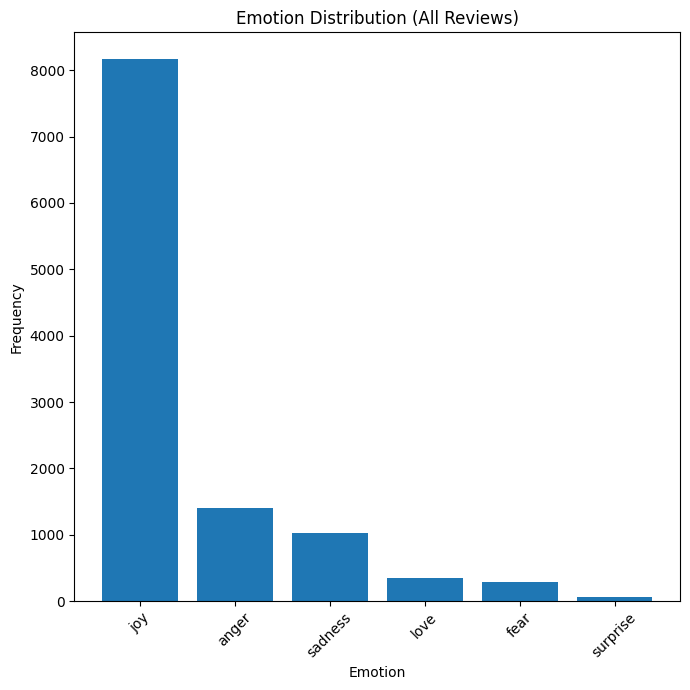

In [ ]:
# Tables and Plots: All reviews
counts_all = df_all_emotion[EmotionParams.LABEL_COL].value_counts(dropna=False)
counts_all_df = counts_all.rename_axis("Emotion").reset_index(name="Count")
display(counts_all_df)

out_path = TABLE_DIR / f"emotion_counts_all_reviews_{MODEL_TAG}.csv"
counts_all_df.to_csv(out_path, index=False)
print("Saved table to:", out_path)

bar_plot(
    counts_all,
    title="Emotion Distribution (All Reviews)",
    x_label="Emotion",
    y_label="Frequency",
    figsize=FIGSIZE,
    show=True,
    save=True,
    output_dir=PLOT_DIR,
    filename=f"emotion_distribution_all_reviews_{MODEL_TAG}.png",
    dpi=DPI,
)


,Emotion,Count
0,joy,868
1,anger,720
2,sadness,580
3,fear,121
4,love,61
5,surprise,18


Saved table to: /Users/Joshua.Dixon/Documents/8_uni/8 Unstructured Data Analysis/Assignment 2/output/tables/04b_emotion_analysis/emotion_counts_negative_reviews_bhadresh_savani_bert_base_uncased_emotion.csv
Saved plot to: /Users/Joshua.Dixon/Documents/8_uni/8 Unstructured Data Analysis/Assignment 2/output/plots/04b_emotion_analysis/emotion_distribution_negative_reviews_bhadresh_savani_bert_base_uncased_emotion.png


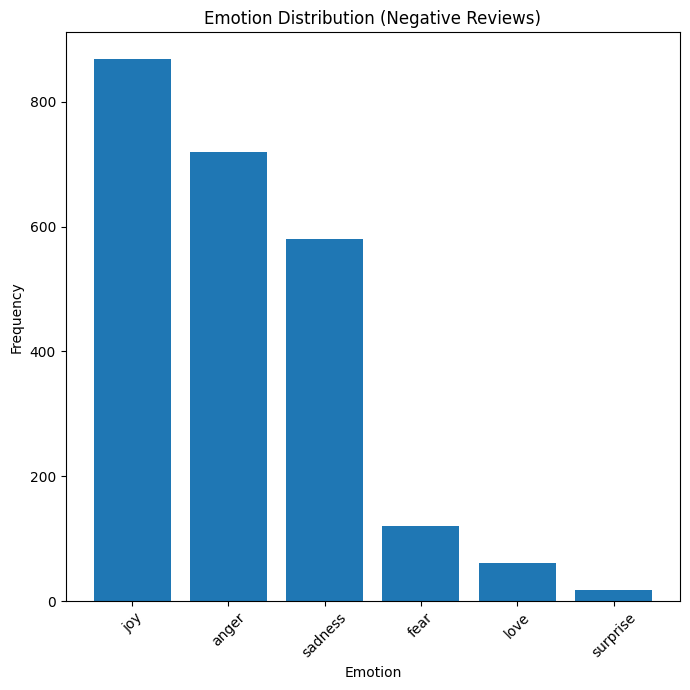

In [ ]:
# Tables and Plots: Negative reviews
counts_neg = df_negative_emotion[EmotionParams.LABEL_COL].value_counts(dropna=False)
counts_neg_df = counts_neg.rename_axis("Emotion").reset_index(name="Count")
display(counts_neg_df)

out_path = TABLE_DIR / f"emotion_counts_negative_reviews_{MODEL_TAG}.csv"
counts_neg_df.to_csv(out_path, index=False)
print("Saved table to:", out_path)

bar_plot(
    counts_neg,
    title="Emotion Distribution (Negative Reviews)",
    x_label="Emotion",
    y_label="Frequency",
    figsize=FIGSIZE,
    show=True,
    save=True,
    output_dir=PLOT_DIR,
    filename=f"emotion_distribution_negative_reviews_{MODEL_TAG}.png",
    dpi=DPI,
)


,Emotion,Count
0,joy,7295
1,anger,682
2,sadness,447
3,love,295
4,fear,166
5,surprise,47


Saved table to: /Users/Joshua.Dixon/Documents/8_uni/8 Unstructured Data Analysis/Assignment 2/output/tables/04b_emotion_analysis/emotion_counts_non_negative_reviews_bhadresh_savani_bert_base_uncased_emotion.csv
Saved plot to: /Users/Joshua.Dixon/Documents/8_uni/8 Unstructured Data Analysis/Assignment 2/output/plots/04b_emotion_analysis/emotion_distribution_non_negative_reviews_bhadresh_savani_bert_base_uncased_emotion.png


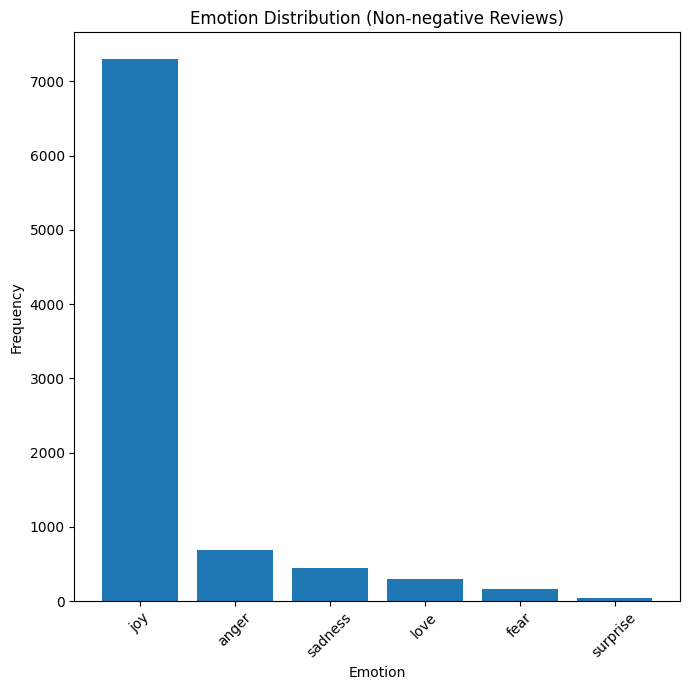

In [ ]:
# Tables and Plots: Non-negative reviews
counts_non_neg = df_non_negative_emotion[EmotionParams.LABEL_COL].value_counts(dropna=False)
counts_non_neg_df = counts_non_neg.rename_axis("Emotion").reset_index(name="Count")
display(counts_non_neg_df)

out_path = TABLE_DIR / f"emotion_counts_non_negative_reviews_{MODEL_TAG}.csv"
counts_non_neg_df.to_csv(out_path, index=False)
print("Saved table to:", out_path)

bar_plot(
    counts_non_neg,
    title="Emotion Distribution (Non-negative Reviews)",
    x_label="Emotion",
    y_label="Frequency",
    figsize=FIGSIZE,
    show=True,
    save=True,
    output_dir=PLOT_DIR,
    filename=f"emotion_distribution_non_negative_reviews_{MODEL_TAG}.png",
    dpi=DPI,
)


In [ ]:
elapsed_s = time.perf_counter() - NOTEBOOK_T0
elapsed_m = elapsed_s / 60

print(f"\nTotal runtime: {elapsed_s:,.1f} seconds ({elapsed_m:,.2f} minutes)")


Total runtime: 89.2 seconds (1.49 minutes)


# 05_topic_modelling_bertopic_per_emotion_neg_reviews

This section applies BERTopic to emotion-specific subsets of negative reviews (e.g. sadness) to obtain emotion-conditioned topics:

- Loads emotion-annotated datasets.

- Filters to negative reviews and subsets by dominant emotion, enforcing a minimum document threshold.

- Fits BERTopic and saves topic summaries and plots.

**Outputs:**

- Models: `output/models/05_topic_modelling_bertopic_per_emotion_neg_reviews/`

- Tables: `output/tables/05_topic_modelling_bertopic_per_emotion_neg_reviews/`

- Plots: `output/plots/05_topic_modelling_bertopic_per_emotion_neg_reviews/`

**Compute and reproducibility:** CPU-only local execution, fixed random seed **901**.


In [ ]:
NOTEBOOK_T0 = time.perf_counter()
print("Section timer started.")

Section timer started.


In [ ]:
# BERTopic Runner
from modelling.bertopic.bertopic_runner import BERTopicRunner

PLOT_DIR = PROJECT_ROOT / CONFIG["OUTPUT"]["PLOT_DIR"] / "05_topic_modelling_bertopic_per_emotion_neg_reviews"
TABLE_DIR = PROJECT_ROOT / CONFIG["OUTPUT"]["TABLE_DIR"] / "05_topic_modelling_bertopic_per_emotion_neg_reviews"
MODEL_DIR = PROJECT_ROOT / CONFIG["OUTPUT"]["MODEL_DIR"] / "05_topic_modelling_bertopic_per_emotion_neg_reviews"

BERTOPIC_NEGATIVE_MODEL = CONFIG["MODELS"]["BERTOPIC_NEGATIVE"]
BERTOPIC_NON_NEGATIVE_MODEL = CONFIG["MODELS"]["BERTOPIC_NON_NEGATIVE"]

EMOTION_COL = CONFIG["FILTERING"]["EMOTION_COL"]

TOP_N_TOPICS = 4
N_WORDS_BARCHART = 5
SHOW_PLOTS = True
SAVE_PNG = True
PNG_SCALE = 2

UMAP_N_NEIGHBOURS = 25
UMAP_N_COMPONENTS = 5
UMAP_MIN_DIST = 0
UMAP_METRIC = "cosine"

MIN_DOCS_PER_EMOTION = 50


In [ ]:
PREPROCESSED_FILENAME_EMOTION = CONFIG["DATA"]["PREPROCESSED_FILENAME_EMOTION"]
PREPROCESSED_FILENAME_NEGATIVE_EMOTION = CONFIG["DATA"]["PREPROCESSED_FILENAME_NEGATIVE_EMOTION"]
PREPROCESSED_FILENAME_NON_NEGATIVE_EMOTION = CONFIG["DATA"]["PREPROCESSED_FILENAME_NON_NEGATIVE_EMOTION"]

ALL_EMOTION_PATH = Path(DATA_DIR) / PREPROCESSED_FILENAME_EMOTION
NEG_EMOTION_PATH = Path(DATA_DIR) / PREPROCESSED_FILENAME_NEGATIVE_EMOTION
NON_NEG_EMOTION_PATH = Path(DATA_DIR) / PREPROCESSED_FILENAME_NON_NEGATIVE_EMOTION

print("ALL_EMOTION_PATH:", ALL_EMOTION_PATH)
print("NEG_EMOTION_PATH:", NEG_EMOTION_PATH)
print("NON_NEG_EMOTION_PATH:", NON_NEG_EMOTION_PATH)

ALL_EMOTION_PATH: /Users/Joshua.Dixon/Documents/8_uni/8 Unstructured Data Analysis/Assignment 2/data/PureGym Customer Reviews_preprocessed_emotion.csv
NEG_EMOTION_PATH: /Users/Joshua.Dixon/Documents/8_uni/8 Unstructured Data Analysis/Assignment 2/data/PureGym Customer Reviews_preprocessed_negative_emotion.csv
NON_NEG_EMOTION_PATH: /Users/Joshua.Dixon/Documents/8_uni/8 Unstructured Data Analysis/Assignment 2/data/PureGym Customer Reviews_preprocessed_non_negative_emotion.csv


In [ ]:
#  Load datasets with emotion column
df_all_emotion = load_csv(ALL_EMOTION_PATH)
df_negative_emotion = load_csv(NEG_EMOTION_PATH)
df_non_negative_emotion = load_csv(NON_NEG_EMOTION_PATH)

print("All emotion-annotated rows:", len(df_all_emotion))
print("Negative emotion-annotated rows:", len(df_negative_emotion))
print("Non-negative emotion-annotated rows:", len(df_non_negative_emotion))


All emotion-annotated rows: 11300
Negative emotion-annotated rows: 2368
Non-negative emotion-annotated rows: 8932


In [ ]:
# Initialise BERTopic runner
runner = BERTopicRunner(
    model_dir=MODEL_DIR,
    plot_dir=PLOT_DIR,
    table_dir=TABLE_DIR,
    seed=SEED,

    # Topic-level controls
    top_n_topics=TOP_N_TOPICS,
    n_words_barchart=N_WORDS_BARCHART,
    min_topic_size = 25,

    # Plotting controls
    show_plots=SHOW_PLOTS,
    save_png=SAVE_PNG,
    png_scale=PNG_SCALE,

    # UMAP controls
    umap_n_neighbors=UMAP_N_NEIGHBOURS,
    umap_n_components=UMAP_N_COMPONENTS,
    umap_min_dist=UMAP_MIN_DIST,
    umap_metric=UMAP_METRIC,
)

#### Sadness (negative reviews)

In [ ]:
# Sadness (negative reviews)
emotion = "sadness"
subset = df_negative_emotion[df_negative_emotion[EMOTION_COL] == emotion].copy()

print(f"\nNegative reviews with dominant emotion = '{emotion}': {len(subset)}")

if len(subset) < MIN_DOCS_PER_EMOTION:
    print(f"Skipping '{emotion}' (only {len(subset)} docs, need at least {MIN_DOCS_PER_EMOTION}).")
else:
    label = f"emotion_negative_{emotion}"
    result_sadness = runner.run(subset, label=label, text_col=TEXT_COL, verbose=True)

    print(result_sadness.plot_paths)

    topic_info_head = result_sadness.topic_info
    top_topics_table = result_sadness.top_topics_table

    topic_info_head.to_csv(TABLE_DIR / f"{label}_topic_info_head10.csv", index=False)
    top_topics_table.to_csv(TABLE_DIR / f"{label}_top_topics_table.csv", index=False)


2026-01-21 02:05:28,736 - BERTopic - Embedding - Transforming documents to embeddings.



Negative reviews with dominant emotion = 'sadness': 712


Batches: 100%|██████████| 23/23 [00:00<00:00, 39.01it/s]
2026-01-21 02:05:31,200 - BERTopic - Embedding - Completed ✓
2026-01-21 02:05:31,200 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-21 02:05:32,045 - BERTopic - Dimensionality - Completed ✓
2026-01-21 02:05:32,046 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-21 02:05:32,055 - BERTopic - Cluster - Completed ✓
2026-01-21 02:05:32,056 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-21 02:05:32,071 - BERTopic - Representation - Completed ✓
2026-01-21 02:05:32,084 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


{'intertopic_distance_html': PosixPath('/Users/Joshua.Dixon/Documents/8_uni/8 Unstructured Data Analysis/Assignment 2/output/plots/05_topic_modelling_bertopic_per_emotion_neg_reviews/bertopic_emotion_negative_sadness_intertopic_distance.html'), 'intertopic_distance_png': PosixPath('/Users/Joshua.Dixon/Documents/8_uni/8 Unstructured Data Analysis/Assignment 2/output/plots/05_topic_modelling_bertopic_per_emotion_neg_reviews/bertopic_emotion_negative_sadness_intertopic_distance.png'), 'barchart_top_topics_html': PosixPath('/Users/Joshua.Dixon/Documents/8_uni/8 Unstructured Data Analysis/Assignment 2/output/plots/05_topic_modelling_bertopic_per_emotion_neg_reviews/bertopic_emotion_negative_sadness_barchart_top4.html'), 'barchart_top_topics_png': PosixPath('/Users/Joshua.Dixon/Documents/8_uni/8 Unstructured Data Analysis/Assignment 2/output/plots/05_topic_modelling_bertopic_per_emotion_neg_reviews/bertopic_emotion_negative_sadness_barchart_top4.png'), 'heatmap_all_topics_html': PosixPath('/

In [ ]:
elapsed_s = time.perf_counter() - NOTEBOOK_T0
elapsed_m = elapsed_s / 60

print(f"\nTotal runtime: {elapsed_s:,.1f} seconds ({elapsed_m:,.2f} minutes)")


Total runtime: 9.2 seconds (0.15 minutes)


# 06_topic_modelling_lda_gensim

This section runs classical topic modelling with Gensim LDA as a baseline against BERTopic:

- Builds dictionary and bag-of-words corpora from preprocessed tokens.

- Trains (or loads) LDA models for multiple subsets (all reviews, negative reviews, and selected emotion subsets).

- Evaluates with c_v coherence and exports topic tables aligned to pyLDAvis numbering.

- Produces interactive pyLDAvis HTML visualisations.

**Outputs:**

- Models and artefacts: `output/models/06_topic_modelling_lda_gensim/` (including `gensim_lda_runs/`)

- Tables: `output/tables/06_topic_modelling_lda_gensim/`

- Visualisations: `output/plots/06_topic_modelling_lda_gensim/`

**Compute and reproducibility:** CPU-only local execution, fixed random seed **901**.


In [ ]:
# Timer start
import time

NOTEBOOK_T0 = time.perf_counter()
print("Notebook timer started.")

Notebook timer started.


In [ ]:

# Gensim imports 
from gensim import corpora
from gensim.corpora import MmCorpus
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from IPython.display import HTML, display

pyLDAvis.enable_notebook()


PREPROCESSED_FILENAME = CONFIG["DATA"]["PREPROCESSED_FILENAME"]
PREPROCESSED_FILENAME_NEGATIVE = CONFIG["DATA"]["PREPROCESSED_FILENAME_NEGATIVE"]
PREPROCESSED_FILENAME_NEGATIVE_EMOTION = CONFIG["DATA"]["PREPROCESSED_FILENAME_NEGATIVE_EMOTION"]

PREPROCESSED_PATH = f"{DATA_DIR}/{PREPROCESSED_FILENAME}"
PREPROCESSED_NEG_PATH = f"{DATA_DIR}/{PREPROCESSED_FILENAME_NEGATIVE}"
PREPROCESSED_NEG_EMO_PATH = f"{DATA_DIR}/{PREPROCESSED_FILENAME_NEGATIVE_EMOTION}"

EMOTION_COL = CONFIG["FILTERING"]["EMOTION_COL"]

# OUTPUT
PLOT_DIR = PROJECT_ROOT / CONFIG["OUTPUT"]["PLOT_DIR"] / "06_topic_modelling_lda_gensim"
TABLE_DIR = PROJECT_ROOT / CONFIG["OUTPUT"]["TABLE_DIR"] / "06_topic_modelling_lda_gensim"
MODEL_DIR = PROJECT_ROOT / CONFIG["OUTPUT"]["MODEL_DIR"] / "06_topic_modelling_lda_gensim"

PLOT_DIR.mkdir(parents=True, exist_ok=True)
TABLE_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)


print("PREPROCESSED_PATH:", PREPROCESSED_PATH)
print("PREPROCESSED_NEG_PATH:", PREPROCESSED_NEG_PATH)
print("PREPROCESSED_NEG_EMO_PATH:", PREPROCESSED_NEG_EMO_PATH)
print("TEXT_COL:", TEXT_COL)
print("EMOTION_COL:", EMOTION_COL)
print("SEED:", SEED)

PREPROCESSED_PATH: /Users/Joshua.Dixon/Documents/8_uni/8 Unstructured Data Analysis/Assignment 2/data/PureGym Customer Reviews_preprocessed.csv
PREPROCESSED_NEG_PATH: /Users/Joshua.Dixon/Documents/8_uni/8 Unstructured Data Analysis/Assignment 2/data/PureGym Customer Reviews_preprocessed_negative.csv
PREPROCESSED_NEG_EMO_PATH: /Users/Joshua.Dixon/Documents/8_uni/8 Unstructured Data Analysis/Assignment 2/data/PureGym Customer Reviews_preprocessed_negative_emotion.csv
TEXT_COL: Review
EMOTION_COL: Dominant Emotion
SEED: 901


## LDA Classes

In [ ]:
@dataclass(frozen=True)
class LDAConfig:
    """
    Configuration for a Gensim LDA run.

    Parameters
    ----------
    ...
    alpha
        Document-topic Dirichlet prior. Can be a float, "symmetric", "asymmetric", or "auto".
    eta
        Topic-word Dirichlet prior. Can be a float, "symmetric", or "auto".
    """

    seed: int
    train_new_model: bool
    num_topics: int
    passes: int
    chunksize: int
    iterations: int
    eval_every: Any
    no_below: int
    no_above: float
    top_n_words: int
    plot_dir: Path
    table_dir: Path
    model_dir: Path
    alpha: Optional[Any] = None
    eta: Optional[Any] = None



@dataclass(frozen=True)
class LDARunResult:
    """
    Outputs from a single LDA run.

    Parameters
    ----------
    label
        Run label used for filenames.
    model_path
        Path to the saved/loaded LDA model.
    dict_path
        Path to the saved dictionary.
    corpus_path
        Path to the saved corpus (.mm).
    topics_csv
        Path to the saved topics summary CSV.
    vis_path
        Path to the saved pyLDAvis HTML file.
    coherence_cv
        c_v coherence score.
    topics_table
        DataFrame of topic ids and top words.
    vis
        pyLDAvis prepared visualisation object.
    """

    label: str
    model_path: Path
    dict_path: Path
    corpus_path: Path
    topics_csv: Path
    vis_path: Path
    coherence_cv: float
    topics_table: pd.DataFrame
    vis: Any


class LDAArtefactStore:
    """Handle file paths and persistence for dictionary, corpus, and model."""

    def __init__(self, model_dir: Path) -> None:
        """
        Parameters
        ----------
        model_dir
            Root directory for saved models and intermediate artefacts.
        """
        self._run_dir = model_dir / "gensim_lda_runs"
        self._run_dir.mkdir(parents=True, exist_ok=True)

    def paths(self, label: str) -> tuple[Path, Path, Path]:
        """
        Get artefact paths for a run label.

        Parameters
        ----------
        label
            Run label.

        Returns
        -------
        tuple[pathlib.Path, pathlib.Path, pathlib.Path]
            (dict_path, corpus_path, model_path)
        """
        dict_path = self._run_dir / f"{label}_dictionary.dict"
        corpus_path = self._run_dir / f"{label}_corpus.mm"
        model_path = self._run_dir / f"{label}_lda_model.gensim"
        return dict_path, corpus_path, model_path

    def save_dictionary(self, dictionary: corpora.Dictionary, path: Path) -> None:
        dictionary.save(str(path))

    def save_corpus(self, corpus: list[list[tuple[int, int]]], path: Path) -> None:
        MmCorpus.serialize(str(path), corpus)

    def save_model(self, model: LdaModel, path: Path) -> None:
        model.save(str(path))

    def load_model(self, path: Path) -> LdaModel:
        return LdaModel.load(str(path))


class LDATrainer:
    """Train a Gensim LDA model."""

    def train(
        self,
        *,
        corpus: list[list[tuple[int, int]]],
        dictionary: corpora.Dictionary,
        config: LDAConfig,
    ) -> LdaModel:
        return LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=config.num_topics,
            passes=config.passes,
            chunksize=config.chunksize,
            iterations=config.iterations,
            random_state=config.seed,
            eval_every=config.eval_every,
            alpha=config.alpha,
            eta=config.eta,
        )



class LDAEvaluator:
    """Compute topic summaries and coherence for an LDA model."""

    @staticmethod
    def _total_tokens(corpus: list[list[tuple[int, int]]]) -> int:
        return int(sum(cnt for doc in corpus for _, cnt in doc))

    @staticmethod
    def _as_vis_dict(vis: Any) -> dict[str, Any]:
        if hasattr(vis, "to_dict"):
            return vis.to_dict()
        if isinstance(vis, dict):
            return vis
        raise TypeError("Expected a pyLDAvis PreparedData object or dict-like representation.")

    @staticmethod
    def _top_terms_from_tinfo(
        tinfo: pd.DataFrame,
        *,
        topic_num: int,
        top_n: int,
        lambda_val: float,
    ) -> list[str]:
        """
        Compute LDAvis relevance ranking for a given topic.

        LDAvis relevance (Sievert & Shirley) uses:
        relevance = lambda * logprob + (1 - lambda) * loglift
        """
        df_t = tinfo[tinfo["Category"] == f"Topic{topic_num}"].copy()
        if df_t.empty:
            return []

        df_t["relevance"] = (lambda_val * df_t["logprob"]) + ((1 - lambda_val) * df_t["loglift"])
        df_t = df_t.sort_values("relevance", ascending=False)
        return df_t["Term"].head(top_n).astype(str).tolist()

    @staticmethod
    def _dominant_topic_counts(
        model: LdaModel,
        corpus: list[list[tuple[int, int]]],
    ) -> dict[int, int]:
        """
        Count documents (reviews) by dominant topic.

        Returns a mapping keyed by pyLDAvis topic numbering (1..K).
        """
        counts: dict[int, int] = {}
        for bow in corpus:
            topic_probs = model.get_document_topics(bow, minimum_probability=0.0)
            dominant_topic = max(topic_probs, key=lambda x: x[1])[0]  # 0-based
            topic_vis = int(dominant_topic) + 1  # pyLDAvis is 1-based
            counts[topic_vis] = counts.get(topic_vis, 0) + 1
        return counts

    def topic_table(
        self,
        model: LdaModel,
        *,
        top_n_words: int,
        vis: Any,
        corpus: list[list[tuple[int, int]]],
        coherence_cv: float,
        lambda_alt: float = 0.1,
    ) -> pd.DataFrame:
        """
        Build a topic summary table, ranked by document count.

        Notes
        -----
        - TopicId matches pyLDAvis numbering (1..K).
        - Topic is 1..K after sorting by Count (largest first).
        - Count is document-level (dominant topic per review).
        """
        vis_d = self._as_vis_dict(vis)

        mds = pd.DataFrame(vis_d["mdsDat"])
        tinfo = pd.DataFrame(vis_d["tinfo"])

        if "topics" not in mds.columns or "Freq" not in mds.columns:
            raise KeyError("pyLDAvis mdsDat is missing expected columns ('topics', 'Freq').")

        doc_counts = self._dominant_topic_counts(model, corpus)

        rows: list[dict[str, Any]] = []
        for topic_num in range(1, model.num_topics + 1):
            count_docs = int(doc_counts.get(int(topic_num), 0))

            top_l1 = self._top_terms_from_tinfo(
                tinfo,
                topic_num=topic_num,
                top_n=top_n_words,
                lambda_val=1.0,
            )
            top_lalt = self._top_terms_from_tinfo(
                tinfo,
                topic_num=topic_num,
                top_n=top_n_words,
                lambda_val=float(lambda_alt),
            )

            rows.append(
                {
                    "TopicId": int(topic_num),
                    "Count": count_docs,
                    "TopWords_lambda_1_0": ", ".join(top_l1),
                    "TopWords_lambda_0_1": ", ".join(top_lalt),
                    "Coherence_c_v": float(coherence_cv),
                }
            )

        df = (
            pd.DataFrame(rows)
            .sort_values(["Count", "TopicId"], ascending=[False, True])
            .reset_index(drop=True)
        )

        df.insert(0, "Topic", range(1, len(df) + 1))
        df = df[["Topic", "TopicId", "Count", "TopWords_lambda_1_0", "TopWords_lambda_0_1", "Coherence_c_v"]]
        return df

    def coherence_cv(
        self,
        *,
        model: LdaModel,
        tokens: list[list[str]],
        dictionary: corpora.Dictionary,
    ) -> float:
        coherence_model = CoherenceModel(model=model, texts=tokens, dictionary=dictionary, coherence="c_v")
        return float(coherence_model.get_coherence())


class LDAVizWriter:
    """Create and persist pyLDAvis artefacts."""

    def build(self, model: LdaModel, corpus: list[list[tuple[int, int]]], dictionary: corpora.Dictionary) -> Any:
        return gensimvis.prepare(model, corpus, dictionary)

    def save_html(self, vis: Any, path: Path) -> None:
        pyLDAvis.save_html(vis, str(path))


class LDARunner:
    """
    Orchestrate an end-to-end LDA run (build, train/load, evaluate, export).

    Notes
    -----
    Output naming convention:
    - {label}_dictionary.dict
    - {label}_corpus.mm
    - {label}_lda_model.gensim
    - {label}_gensim_lda_topics.csv
    - {label}_gensim_lda_intertopic_map.html
    """

    def __init__(
        self,
        config: LDAConfig,
        *,
        tokeniser: Any,
        builder: Any,
        store: Optional[LDAArtefactStore] = None,
        trainer: Optional[LDATrainer] = None,
        evaluator: Optional[LDAEvaluator] = None,
        viz: Optional[LDAVizWriter] = None,
    ) -> None:
        self.cfg = config
        np.random.seed(self.cfg.seed)

        self.tokeniser = tokeniser
        self.builder = builder
        self.store = store or LDAArtefactStore(self.cfg.model_dir)
        self.trainer = trainer or LDATrainer()
        self.evaluator = evaluator or LDAEvaluator()
        self.viz = viz or LDAVizWriter()

    def run(self, *, tokens: list[list[str]], label: str, show_vis: bool = True) -> LDARunResult:
        if len(tokens) == 0:
            raise ValueError(f"{label}: no documents after cleaning/tokenisation.")

        dict_path, corpus_path, model_path = self.store.paths(label)

        dictionary = self.builder.build_dictionary(tokens, no_below=self.cfg.no_below, no_above=self.cfg.no_above)
        corpus = self.builder.build_bow(tokens, dictionary)

        if len(dictionary) == 0 or len(corpus) == 0:
            raise ValueError(
                f"{label}: corpus/dictionary empty. Try relaxing no_below/no_above or check preprocessing."
            )

        self.store.save_dictionary(dictionary, dict_path)
        self.store.save_corpus(corpus, corpus_path)

        if self.cfg.train_new_model:
            model = self.trainer.train(corpus=corpus, dictionary=dictionary, config=self.cfg)
            self.store.save_model(model, model_path)
        else:
            model = self.store.load_model(model_path)

        coherence_cv = self.evaluator.coherence_cv(model=model, tokens=tokens, dictionary=dictionary)

        vis = self.viz.build(model, corpus, dictionary)
        vis_path = self.cfg.plot_dir / f"{label}_gensim_lda_intertopic_map.html"
        self.viz.save_html(vis, vis_path)

        # Topic table aligned to pyLDAvis topic numbering 
        # Count is now document-level (dominant topic per review).
        topics_table = self.evaluator.topic_table(
            model,
            top_n_words=self.cfg.top_n_words,
            vis=vis,
            corpus=corpus,
            coherence_cv=coherence_cv,
            lambda_alt=0.1,
        )

        topics_csv = self.cfg.table_dir / f"{label}_gensim_lda_topics.csv"
        topics_table.to_csv(topics_csv, index=False)

        result = LDARunResult(
            label=label,
            model_path=model_path,
            dict_path=dict_path,
            corpus_path=corpus_path,
            topics_csv=topics_csv,
            vis_path=vis_path,
            coherence_cv=coherence_cv,
            topics_table=topics_table,
            vis=vis,
        )

        print("Saved:", result.topics_csv)
        print("Saved:", result.vis_path)
        print("Coherence (c_v):", round(result.coherence_cv, 4))
        display(result.topics_table)

        if show_vis:
            display(HTML(pyLDAvis.prepared_data_to_html(result.vis)))

        return result

    @staticmethod
    def summary_row(result: LDARunResult) -> dict[str, Any]:
        return {
            "Label": result.label,
            "TopicsCSV": str(result.topics_csv),
            "VisHTML": str(result.vis_path),
            "Coherence_c_v": result.coherence_cv,
        }

In [ ]:
TokenNormaliser = Callable[[str], list[str]]

class PreprocessedTokeniser:
    """Tokenise preprocessed text into token lists."""

    def __init__(self, *, normaliser: Optional[TokenNormaliser] = None) -> None:
        """
        Parameters
        ----------
        normaliser
            Optional token normaliser applied per whitespace token.
            If None, tokens are returned unchanged (whitespace split only).
        """
        self._normaliser = normaliser
        self._ws_re = re.compile(r"\s+")

    def transform(self, series: pd.Series) -> list[list[str]]:
        """
        Convert a Series of strings into token lists.

        Parameters
        ----------
        series
            Series containing preprocessed text.

        Returns
        -------
        list[list[str]]
            Token lists, one per non-empty document.
        """
        texts = series.fillna("").astype(str).str.strip()
        texts = texts.loc[texts.ne("")]
        texts = texts.str.replace(self._ws_re, " ", regex=True).str.strip()

        docs: list[list[str]] = []
        for text in texts.tolist():
            raw_tokens = text.split()

            if self._normaliser is None:
                doc_tokens = raw_tokens
            else:
                doc_tokens = []
                for tok in raw_tokens:
                    doc_tokens.extend(self._normaliser(tok))

            if doc_tokens:
                docs.append(doc_tokens)

        return docs

    def describe(self, label: str, tokens: list[list[str]]) -> None:
        """
        Print summary statistics for a tokenised corpus.

        Parameters
        ----------
        label
            Short label for printed output.
        tokens
            Tokenised documents.
        """
        doc_count = len(tokens)
        total_tokens = sum(len(t) for t in tokens)
        avg_len = total_tokens / doc_count if doc_count else 0
        print(f"{label}: docs={doc_count:,} total_tokens={total_tokens:,} avg_doc_len={avg_len:.1f}")


In [ ]:
class GensimCorpusBuilder:
    """Build a Gensim dictionary and BoW corpus from tokenised documents."""

    def build_dictionary(self, tokens: list[list[str]], *, no_below: int, no_above: float) -> corpora.Dictionary:
        """
        Create and filter a Gensim dictionary.

        Parameters
        ----------
        tokens
            Tokenised documents.
        no_below
            Minimum document frequency threshold.
        no_above
            Maximum document frequency fraction threshold.

        Returns
        -------
        gensim.corpora.Dictionary
            Filtered dictionary.
        """
        dictionary = corpora.Dictionary(tokens)
        dictionary.filter_extremes(no_below=no_below, no_above=no_above)
        return dictionary

    def build_bow(self, tokens: list[list[str]], dictionary: corpora.Dictionary) -> list[list[tuple[int, int]]]:
        """
        Convert documents into BoW count vectors.

        Parameters
        ----------
        tokens
            Tokenised documents.
        dictionary
            Token-id mapping.

        Returns
        -------
        list[list[tuple[int, int]]]
            BoW corpus in (token_id, count) format.
        """
        return [dictionary.doc2bow(doc) for doc in tokens]

## Analysis

In [ ]:
# Loads CSVs
df_preprocessed = load_csv(PREPROCESSED_PATH)
df_preprocessed_negative = load_csv(PREPROCESSED_NEG_PATH)
df_preprocessed_negative_emotion = load_csv(PREPROCESSED_NEG_EMO_PATH)

print("df_preprocessed rows:", len(df_preprocessed))
print("df_preprocessed_negative rows:", len(df_preprocessed_negative))
print("df_preprocessed_negative_emotion rows:", len(df_preprocessed_negative_emotion))

df_preprocessed rows: 11300
df_preprocessed_negative rows: 2368
df_preprocessed_negative_emotion rows: 2368


In [ ]:
# LDA settings

TRAIN_NEW_MODEL = True  # If True, trains a fresh LDA model and overwrites saved artefacts

NUM_TOPICS = 5      # Number of latent topics (K) - lower creates broader topics
PASSES = 10         # Number of full epochs over the whole corpus
CHUNKSIZE = 100     # Documents processed per training chunk
ITERATIONS = 1000    # Higher to improve stability/convergence but increase runtime.
EVAL_EVERY = None   # None disables evaluation (faster).

NO_BELOW = 10       # drop tokens that appear in fewer than this many documents (removes rare noise terms).
NO_ABOVE = 0.25      #  drop tokens that appear in more than this fraction of documents (removes very common terms).
TOP_N_WORDS = 5   #  how many top words per topic to export/display (does not affect model training).

ALPHA = "asymmetric"    # Document-topic prior. Lower/more uneven values encourage fewer topics per document and can reduce topic mixing.
ETA = "auto"            # Topic-word prior. Lower values encourage sharper, more distinctive topic vocabularies; "auto" learns this from data.

print("TRAIN_NEW_MODEL:", TRAIN_NEW_MODEL)
print("NUM_TOPICS:", NUM_TOPICS)
print("NO_BELOW / NO_ABOVE:", NO_BELOW, NO_ABOVE)
print("ALPHA:", ALPHA)
print("ETA:", ETA)




TRAIN_NEW_MODEL: True
NUM_TOPICS: 5
NO_BELOW / NO_ABOVE: 10 0.25
ALPHA: asymmetric
ETA: auto


In [ ]:
tokeniser = PreprocessedTokeniser()
builder = GensimCorpusBuilder()

lda_cfg = LDAConfig(
    seed=SEED,
    train_new_model=TRAIN_NEW_MODEL,
    num_topics=NUM_TOPICS,
    passes=PASSES,
    chunksize=CHUNKSIZE,
    iterations=ITERATIONS,
    eval_every=EVAL_EVERY,
    no_below=NO_BELOW,
    no_above=NO_ABOVE,
    top_n_words=TOP_N_WORDS,
    plot_dir=PLOT_DIR,
    table_dir=TABLE_DIR,
    model_dir=MODEL_DIR,
    alpha=ALPHA,
    eta=ETA,
)

lda_runner = LDARunner(lda_cfg, tokeniser=tokeniser, builder=builder)

In [ ]:
tokens_negative = lda_runner.tokeniser.transform(df_preprocessed_negative[TEXT_COL])
lda_runner.tokeniser.describe("NEG", tokens_negative)
result_negative = lda_runner.run(tokens=tokens_negative, label="lda_preprocessed_negative")

NEG: docs=2,368 total_tokens=79,619 avg_doc_len=33.6
Saved: /Users/Joshua.Dixon/Documents/8_uni/8 Unstructured Data Analysis/Assignment 2/output/tables/06_topic_modelling_lda_gensim/lda_preprocessed_negative_gensim_lda_topics.csv
Saved: /Users/Joshua.Dixon/Documents/8_uni/8 Unstructured Data Analysis/Assignment 2/output/plots/06_topic_modelling_lda_gensim/lda_preprocessed_negative_gensim_lda_intertopic_map.html
Coherence (c_v): 0.4031


,Topic,TopicId,Count,TopWords_lambda_1_0,TopWords_lambda_0_1,Coherence_c_v
0,1,1,1150,"time, member, room, people, one","room, changing, toilet, locker, open",0.403075
1,2,2,558,"staff, member, shower, water, like","water, air, hot, access, cold",0.403075
2,3,5,460,"class, hour, time, spin, early","class, spin, early, min, instructor",0.403075
3,4,3,166,"membership, customer, email, service, month","membership, email, cancel, £, cancelled",0.403075
4,5,4,34,"machine, weight, area, space, busy","weight, space, amount, cleaned, machine",0.403075


### Run Emotion Subsets on Negative Reviews

In [ ]:
# LDA settings

TRAIN_NEW_MODEL = True 

NUM_TOPICS = 3      
PASSES = 10        
CHUNKSIZE = 100     
ITERATIONS = 1000    
EVAL_EVERY = None   

NO_BELOW = 10       
NO_ABOVE = 0.3     
TOP_N_WORDS = 5   

ALPHA = "asymmetric"    
ETA = "auto"           

print("TRAIN_NEW_MODEL:", TRAIN_NEW_MODEL)
print("NUM_TOPICS:", NUM_TOPICS)
print("NO_BELOW / NO_ABOVE:", NO_BELOW, NO_ABOVE)
print("ALPHA:", ALPHA)
print("ETA:", ETA)


TRAIN_NEW_MODEL: True
NUM_TOPICS: 3
NO_BELOW / NO_ABOVE: 10 0.3
ALPHA: asymmetric
ETA: auto


In [ ]:
lda_cfg = LDAConfig(
    seed=SEED,
    train_new_model=TRAIN_NEW_MODEL,
    num_topics=NUM_TOPICS,
    passes=PASSES,
    chunksize=CHUNKSIZE,
    iterations=ITERATIONS,
    eval_every=EVAL_EVERY,
    no_below=NO_BELOW,
    no_above=NO_ABOVE,
    top_n_words=TOP_N_WORDS,
    plot_dir=PLOT_DIR,
    table_dir=TABLE_DIR,
    model_dir=MODEL_DIR,
    alpha=ALPHA,
    eta=ETA,
)

lda_runner = LDARunner(lda_cfg, tokeniser=tokeniser, builder=builder)

In [ ]:
def run_emotion_subset(emotion: str) -> LDARunResult:
    df_sub = df_preprocessed_negative_emotion[df_preprocessed_negative_emotion[EMOTION_COL] == emotion].copy()
    print(f"Negative emotion rows ({emotion}):", len(df_sub))
    tokens = lda_runner.tokeniser.transform(df_sub[TEXT_COL])
    lda_runner.tokeniser.describe(emotion.upper(), tokens)
    return lda_runner.run(tokens=tokens, label=f"lda_preprocessed_negative_emotion_{emotion}")

In [ ]:
result_neg_sadness = run_emotion_subset("sadness")

Negative emotion rows (sadness): 712
SADNESS: docs=712 total_tokens=25,365 avg_doc_len=35.6
Saved: /Users/Joshua.Dixon/Documents/8_uni/8 Unstructured Data Analysis/Assignment 2/output/tables/06_topic_modelling_lda_gensim/lda_preprocessed_negative_emotion_sadness_gensim_lda_topics.csv
Saved: /Users/Joshua.Dixon/Documents/8_uni/8 Unstructured Data Analysis/Assignment 2/output/plots/06_topic_modelling_lda_gensim/lda_preprocessed_negative_emotion_sadness_gensim_lda_intertopic_map.html
Coherence (c_v): 0.3983


,Topic,TopicId,Count,TopWords_lambda_1_0,TopWords_lambda_0_1,Coherence_c_v
0,1,1,429,"shower, change, go, time, member","shower, order, clean, bad, leave",0.398338
1,2,3,182,"machine, open, weight, since, space","weight, space, press, free, workout",0.398338
2,3,2,101,"cancel, class, membership, get, pay","cancel, membership, subscription, freeze, say",0.398338


In [ ]:
summary_rows = [
    lda_runner.summary_row(result_negative),
    lda_runner.summary_row(result_neg_sadness)
]

df_summary = pd.DataFrame(summary_rows)
display(df_summary)

,Label,TopicsCSV,VisHTML,Coherence_c_v
0,lda_preprocessed_negative,/Users/Joshua.Dixon/Documents/8_uni/8 Unstructured Data Analysis/Assignment 2/output/tables/06_topic_modelling_lda_gensim/lda_preprocessed_negative_gensim_lda_topics.csv,/Users/Joshua.Dixon/Documents/8_uni/8 Unstructured Data Analysis/Assignment 2/output/plots/06_topic_modelling_lda_gensim/lda_preprocessed_negative_gensim_lda_intertopic_map.html,0.403075
1,lda_preprocessed_negative_emotion_sadness,/Users/Joshua.Dixon/Documents/8_uni/8 Unstructured Data Analysis/Assignment 2/output/tables/06_topic_modelling_lda_gensim/lda_preprocessed_negative_emotion_sadness_gensim_lda_topics.csv,/Users/Joshua.Dixon/Documents/8_uni/8 Unstructured Data Analysis/Assignment 2/output/plots/06_topic_modelling_lda_gensim/lda_preprocessed_negative_emotion_sadness_gensim_lda_intertopic_map.html,0.398338


In [ ]:
elapsed_s = time.perf_counter() - NOTEBOOK_T0
elapsed_m = elapsed_s / 60
print(f"\nTotal runtime: {elapsed_s:,.1f} seconds ({elapsed_m:,.2f} minutes)")


Total runtime: 6.5 seconds (0.11 minutes)


In [ ]:
elapsed_s_global = time.perf_counter() - NOTEBOOK_T0_GLOBAL
elapsed_m_global = elapsed_s_global / 60

print(f"\nFull notebook total runtime: {elapsed_s_global:,.1f} seconds ({elapsed_m_global:,.2f} minutes)")


Full notebook total runtime: 205.6 seconds (3.43 minutes)
